In [1]:
import torch
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the data

routine.py

In [2]:
def coth(a):
    if a>0: return (1+np.exp(-2*a))/(1-np.exp(-2*a))
    if a<0: return (np.exp(2*a)+1)/(np.exp(2*a)-1)
    if a==0: return 0

m2=-1.0
lamb=1.0
N_layer=10
eta_fin=1/N_layer
eta_ini=1
del_eta=(eta_fin-eta_ini)/N_layer
h_real=np.array([3*coth(3*((i-N_layer)*del_eta)) for i in range (N_layer)])

def LP2(hh, phi, pi):
    for j in range (N_layer-1):
        phi1=phi+del_eta*pi
        pi1 =phi*m2*del_eta+(1-del_eta*hh[j])*pi+del_eta*lamb*(phi1**3)
        phi=phi1
        pi=pi1
    return phi, pi

def F_func(a,b):
    return 2*b/eta_fin-m2*a-lamb*(a**3)

def t(a):
    return 0.5*(torch.tanh(100*(a-0.1))-torch.tanh(100*(a+0.1))+2)

def generate_data(datasize=1000, Hrange=[0.0, 1.5], Mrange=[-0.2, 0.2]):
    Hp=[]
    Mp=[]
    Fp=[]
    Hn=[]
    Mn=[]
    Fn=[]
    while True:
        H=np.random.uniform(Hrange[0], Hrange[1], datasize)
        M=np.random.uniform(Mrange[0], Mrange[1], datasize)
        HH, MM = LP2(h_real, H, M)
        F=np.array(np.abs(F_func(HH, MM)))
        for i in range (len(H[F<0.1])):
            if len(Fp)>=datasize: break
            Hp.append([H[F<0.1][i]])
            Mp.append([M[F<0.1][i]])
            Fp.append([0])
        for j in range (len(H[F>=0.1])):
            if len(Fn)>=datasize: break
            Hn.append([H[F>=0.1][j]])
            Mn.append([M[F>=0.1][j]])
            Fn.append([1])
        if len(Fp)>=datasize and len(Fn)>=datasize:
            break
    return (np.array(Hp), np.array(Mp), np.array(Fp)), (np.array(Hn), np.array(Mn), np.array(Fn))

def plot_all(Positive_HM, Negative_HM):
    print(len(Positive_HM[2]), len(Negative_HM[2]))
    plt.xlabel('phi')
    plt.ylabel('pi')
    plt.plot(Negative_HM[0], Negative_HM[1], 'g.', label='negative')
    plt.plot(Positive_HM[0], Positive_HM[1], 'r.', label='positive')
    plt.legend(loc='upper right',bbox_to_anchor=(1.05, 0.5, 0.5, .100))
    plt.show()

1000 1000


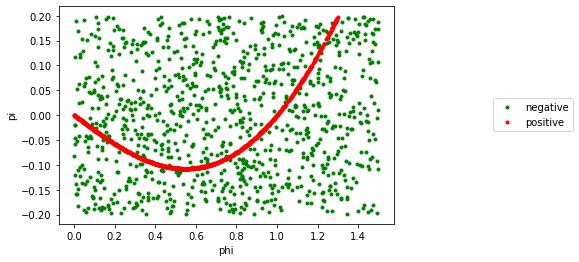

In [3]:
Positive_HM, Negative_HM = generate_data(datasize=1000)
plot_all(Positive_HM, Negative_HM)

## Reformat training data
Make training data by class called 'Dataset'.

In [4]:
class phi_pi_dataset:
    def __init__(self, Positive_HM, Negative_HM, transform=None):
        self.phi=np.concatenate((Positive_HM[0], Negative_HM[0]), axis=0).astype(np.float32)
        self.pi=np.concatenate((Positive_HM[1], Negative_HM[1]), axis=0).astype(np.float32)
        self.ans = np.concatenate((Positive_HM[2], Negative_HM[2]), axis=0).astype(np.float32)
        self.transform=transform
    def __getitem__(self, index):
        phi=self.phi[index]
        pi=self.pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi=self.transform(phi)
            pi=self.transform(pi)
            ans = self.transform(ans)
        return phi, pi, ans
    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(phi_pi_dataset(
                                Positive_HM=Positive_HM, 
                                Negative_HM=Negative_HM, 
                                transform=transforms.Compose([torch.from_numpy])), 
                                batch_size=100, shuffle=True)

# 2. Make a Neural network
neuralnet.py

In [6]:
import torch.nn as nn
import torch.nn.functional as F

def onestep(phi, pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*pi
    pi1 = phi*m2*del_eta + (1-del_eta*hh)*pi + del_eta*lamb*(phi1**3)
    return phi1, pi1

def f(phi, pi):
    return pi

class Metricnet(nn.Module):
    def __init__(self, N_layer=None, eta_ini=None, eta_fin=None, del_eta=None, d=None):
        super(Metricnet, self).__init__()
        
        #trained parameters
        Hs=[]
        for layer_index in range (N_layer):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs=nn.ModuleList(Hs)
        
        #fixed parameters
        self.lamb=lamb
        self.m2=m2
        self.N_layer=N_layer
        self.eta_ini=eta_ini
        self.eta_fin=eta_fin
        self.del_eta=del_eta
        self.d=d
        self.one=Variable(torch.ones(1))
    
    def show_Hs(self):
        a=[]
        for i in range (N_layer):
            aa=self.Hs[i](self.one).data.numpy()[0]
            a.append(aa)
        return a
    
    def penalty(self):
        pen=0
        for i in range (self.N_layer-1):
            H1=self.Hs[i](self.one)
            H2=self.Hs[i+1](self.one)
            pen=pen+c_reg1*((eta_ini+i*del_eta)**4)*((H2-H1)**2)
        pen=pen+c_reg2*((self.Hs[N_layer-1](self.one)-N_layer)**2)
        return pen
    
    def forward(self, phi=None, pi=None):
        for i in range (self.N_layer-1):
            phi, pi = onestep(phi, pi, hh=self.Hs[i](self.one), m2=self.m2, 
                              lamb=self.lamb, del_eta=self.del_eta)
        ff=f(phi, pi)
        final=t(ff)
        return final
    
    def loss(self, phi=None, pi=None, answer=None):
        model_output=self.forward(phi=phi, pi=pi)
        loss=F.l1_loss(model_output, answer)**2
        loss=loss+self.penalty()
        return loss

def init_weights(Model):
    for i in range (len(Model.Hs)):
        mu=1/(eta_ini+del_eta*i)
        w=np.random.normal(mu, 1)
        Model.Hs[i].weight.data.fill_(w)   

In [7]:
c_reg1=0.005
c_reg2=0.000

#make network
Test=Metricnet(N_layer=N_layer, eta_ini=eta_ini, eta_fin=eta_fin, del_eta=del_eta)
init_weights(Test)

In [8]:
#setting it to be trained
optimizer = torch.optim.Adam(Test.parameters())
Test.train()

Metricnet(
  (Hs): ModuleList(
    (0): Linear(in_features=1, out_features=1, bias=False)
    (1): Linear(in_features=1, out_features=1, bias=False)
    (2): Linear(in_features=1, out_features=1, bias=False)
    (3): Linear(in_features=1, out_features=1, bias=False)
    (4): Linear(in_features=1, out_features=1, bias=False)
    (5): Linear(in_features=1, out_features=1, bias=False)
    (6): Linear(in_features=1, out_features=1, bias=False)
    (7): Linear(in_features=1, out_features=1, bias=False)
    (8): Linear(in_features=1, out_features=1, bias=False)
    (9): Linear(in_features=1, out_features=1, bias=False)
  )
)

# 3. Train NN

In [9]:
def plot_metric(threshold=None, Positive_HM=None, Negative_HM=None, Net=None):
    NN_pphi=[]
    NN_ppi=[]
    Negative_H = Negative_HM[0]
    Negative_M = Negative_HM[1]
    phis = Variable(torch.from_numpy(Negative_H.astype(np.float32)))
    pis = Variable(torch.from_numpy(Negative_M.astype(np.float32)))
    predict = Net.forward(phi=phis, pi=pis).data.numpy()
    
    for index in range (len(Negative_H)):
        value = predict[index]
        if value < threshold:
            NN_pphi.append(Negative_H[index])
            NN_ppi.append(Negative_M[index])
    NN_pphi1=np.array(NN_pphi)
    NN_ppi1=np.array(NN_ppi)
    
    NN_pphi=[]
    NN_ppi=[]
    Positive_H = Positive_HM[0]
    Positive_M = Positive_HM[1]
    phis = Variable(torch.from_numpy(Positive_H.astype(np.float32)))
    pis = Variable(torch.from_numpy(Positive_M.astype(np.float32)))
    predict = Net.forward(phi=phis, pi=pis).data.numpy()
    
    for index in range (len(phis)):
        value = predict[index]
        if value < threshold:
            NN_pphi.append(Positive_H[index])
            NN_ppi.append(Positive_M[index])
    NN_pphi2=np.array(NN_pphi)
    NN_ppi2=np.array(NN_ppi)
    
    plt.plot(NN_pphi1, NN_ppi1, 'm.', label='NN(n)=0')
    plt.plot(NN_pphi2, NN_ppi2, 'r.', label='NN(p)=0')
    plt.show()
    
    x = np.array([0.1*i for i in range (10)])
    NN_list=[]
    for param in Net.Hs.parameters():
        w = (param.data.numpy().reshape(-1)).tolist()
        NN_list.append(w)
    plt.plot(x, h_real, 'r-')
    plt.plot(x, np.array(NN_list), 'k-')
    plt.show()
    
    return NN_pphi1, NN_ppi1, NN_pphi2, NN_ppi2, NN_list

0 tensor(0.2395)


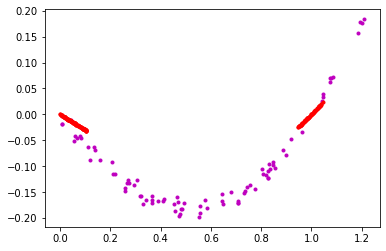

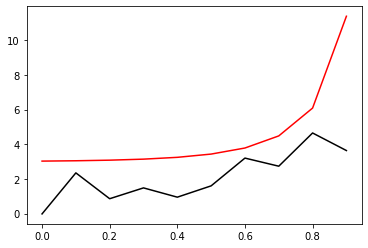

[-0.017911559, 2.3482602, 0.8584184, 1.4828615, 0.94785964, 1.6000962, 3.201035, 2.7334845, 4.648701, 3.635652]
1 tensor(0.2385)
2 tensor(0.2357)
3 tensor(0.2337)
4 tensor(0.2323)
5 tensor(0.2319)
6 tensor(0.2309)
7 tensor(0.2294)
8 tensor(0.2274)
9 tensor(0.2280)
10 tensor(0.2247)
11 tensor(0.2234)
12 tensor(0.2220)
13 tensor(0.2199)
14 tensor(0.2196)
15 tensor(0.2178)
16 tensor(0.2171)
17 tensor(0.2157)
18 tensor(0.2140)
19 tensor(0.2113)
20 tensor(0.2100)
21 tensor(0.2084)
22 tensor(0.2067)
23 tensor(0.2060)
24 tensor(0.2034)
25 tensor(0.2055)
26 tensor(0.2024)
27 tensor(0.1987)
28 tensor(0.1982)
29 tensor(0.1976)
30 tensor(0.1964)
31 tensor(0.1957)
32 tensor(0.1944)
33 tensor(0.1939)
34 tensor(0.1938)
35 tensor(0.1927)
36 tensor(0.1931)
37 tensor(0.1913)
38 tensor(0.1919)
39 tensor(0.1894)
40 tensor(0.1882)
41 tensor(0.1905)
42 tensor(0.1877)
43 tensor(0.1874)
44 tensor(0.1889)
45 tensor(0.1883)
46 tensor(0.1871)
47 tensor(0.1854)
48 tensor(0.1851)
49 tensor(0.1862)
50 tensor(0.186

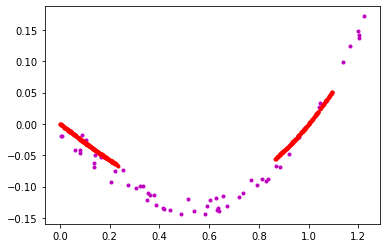

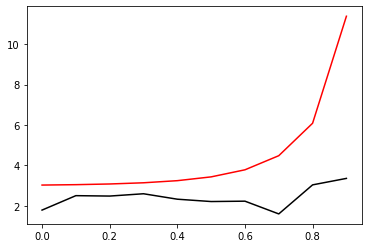

[1.7891947, 2.5032952, 2.4830093, 2.5972362, 2.328086, 2.2120953, 2.2304873, 1.5997756, 3.0370758, 3.3569148]
101 tensor(0.0979)
102 tensor(0.0945)
103 tensor(0.0913)
104 tensor(0.0866)
105 tensor(0.0809)
106 tensor(0.0752)
107 tensor(0.0670)
108 tensor(0.0582)
109 tensor(0.0490)
110 tensor(0.0373)
111 tensor(0.0254)
112 tensor(0.0155)
113 tensor(0.0112)
114 tensor(0.0096)
115 tensor(0.0084)
116 tensor(0.0081)
117 tensor(0.0077)
118 tensor(0.0076)
119 tensor(0.0074)
120 tensor(0.0070)
121 tensor(0.0067)
122 tensor(0.0066)
123 tensor(0.0066)
124 tensor(0.0063)
125 tensor(0.0063)
126 tensor(0.0061)
127 tensor(0.0062)
128 tensor(0.0058)
129 tensor(0.0059)
130 tensor(0.0058)
131 tensor(0.0056)
132 tensor(0.0056)
133 tensor(0.0056)
134 tensor(0.0054)
135 tensor(0.0054)
136 tensor(0.0053)
137 tensor(0.0051)
138 tensor(0.0050)
139 tensor(0.0050)
140 tensor(0.0050)
141 tensor(0.0047)
142 tensor(0.0050)
143 tensor(0.0049)
144 tensor(0.0046)
145 tensor(0.0047)
146 tensor(0.0047)
147 tensor(0.005

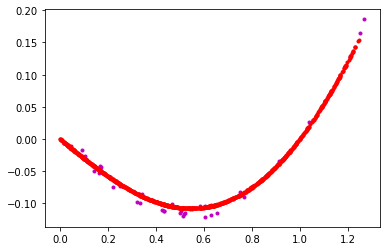

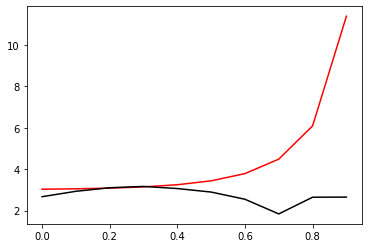

[2.6664147, 2.9270897, 3.0989969, 3.1620283, 3.0606627, 2.890686, 2.543292, 1.835303, 2.641769, 2.6474886]
201 tensor(0.0017)
202 tensor(0.0017)
203 tensor(0.0016)
204 tensor(0.0015)
205 tensor(0.0015)
206 tensor(0.0014)
207 tensor(0.0014)
208 tensor(0.0013)
209 tensor(0.0013)
210 tensor(0.0013)
211 tensor(0.0012)
212 tensor(0.0013)
213 tensor(0.0012)
214 tensor(0.0012)
215 tensor(0.0011)
216 tensor(0.0011)
217 tensor(0.0010)
218 tensor(0.0012)
219 tensor(0.0011)
220 tensor(0.0011)
221 tensor(0.0010)
222 tensor(0.0011)
223 tensor(0.0011)
224 tensor(0.0011)
225 tensor(0.0010)
226 tensor(0.0010)
227 tensor(0.0011)
228 tensor(0.0009)
229 tensor(0.0010)
230 tensor(0.0010)
231 tensor(0.0009)
232 tensor(0.0009)
233 tensor(0.0009)
234 tensor(0.0009)
235 tensor(0.0009)
236 tensor(0.0009)
237 tensor(0.0009)
238 tensor(0.0009)
239 tensor(0.0008)
240 tensor(0.0009)
241 tensor(0.0009)
242 tensor(0.0009)
243 tensor(0.0008)
244 tensor(0.0008)
245 tensor(0.0008)
246 tensor(0.0009)
247 tensor(0.0008)


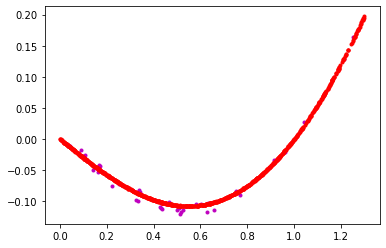

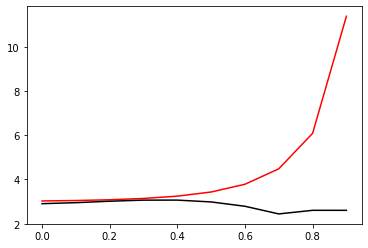

[2.9043994, 2.9496827, 3.0151453, 3.064176, 3.0655987, 2.982663, 2.7869315, 2.4411926, 2.6039002, 2.6034176]
301 tensor(0.0006)
302 tensor(0.0006)
303 tensor(0.0006)
304 tensor(0.0005)
305 tensor(0.0006)
306 tensor(0.0005)
307 tensor(0.0005)
308 tensor(0.0006)
309 tensor(0.0006)
310 tensor(0.0006)
311 tensor(0.0006)
312 tensor(0.0005)
313 tensor(0.0006)
314 tensor(0.0006)
315 tensor(0.0006)
316 tensor(0.0005)
317 tensor(0.0006)
318 tensor(0.0005)
319 tensor(0.0006)
320 tensor(0.0005)
321 tensor(0.0006)
322 tensor(0.0005)
323 tensor(0.0007)
324 tensor(0.0005)
325 tensor(0.0007)
326 tensor(0.0005)
327 tensor(0.0006)
328 tensor(0.0005)
329 tensor(0.0005)
330 tensor(0.0005)
331 tensor(0.0006)
332 tensor(0.0005)
333 tensor(0.0005)
334 tensor(0.0006)
335 tensor(0.0006)
336 tensor(0.0005)
337 tensor(0.0006)
338 tensor(0.0007)
339 tensor(0.0004)
340 tensor(0.0007)
341 tensor(0.0006)
342 tensor(0.0006)
343 tensor(0.0006)
344 tensor(0.0006)
345 tensor(0.0005)
346 tensor(0.0005)
347 tensor(0.0005

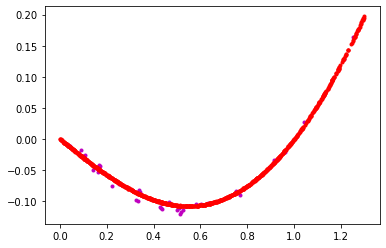

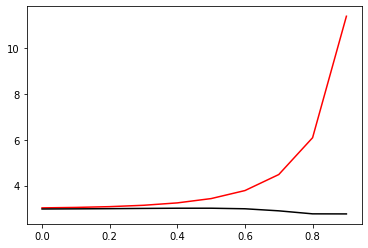

[2.978922, 2.9846222, 2.9930634, 3.003621, 3.0121336, 3.0124793, 2.9880893, 2.8985386, 2.767067, 2.7639377]
401 tensor(0.0005)
402 tensor(0.0005)
403 tensor(0.0005)
404 tensor(0.0005)
405 tensor(0.0005)
406 tensor(0.0004)
407 tensor(0.0004)
408 tensor(0.0005)
409 tensor(0.0005)
410 tensor(0.0005)
411 tensor(0.0005)
412 tensor(0.0006)
413 tensor(0.0004)
414 tensor(0.0005)
415 tensor(0.0006)
416 tensor(0.0005)
417 tensor(0.0005)
418 tensor(0.0005)
419 tensor(0.0005)
420 tensor(0.0005)
421 tensor(0.0006)
422 tensor(0.0004)
423 tensor(0.0004)
424 tensor(0.0004)
425 tensor(0.0005)
426 tensor(0.0004)
427 tensor(0.0004)
428 tensor(0.0004)
429 tensor(0.0005)
430 tensor(0.0005)
431 tensor(0.0004)
432 tensor(0.0005)
433 tensor(0.0005)
434 tensor(0.0005)
435 tensor(0.0005)
436 tensor(0.0005)
437 tensor(0.0005)
438 tensor(0.0005)
439 tensor(0.0005)
440 tensor(0.0004)
441 tensor(0.0004)
442 tensor(0.0005)
443 tensor(0.0004)
444 tensor(0.0005)
445 tensor(0.0006)
446 tensor(0.0004)
447 tensor(0.0005)

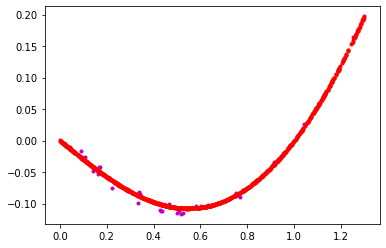

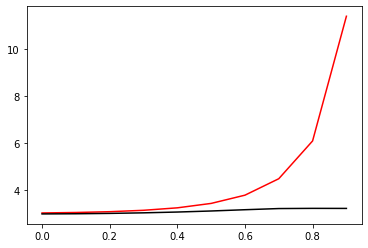

[2.9863605, 2.9933095, 3.00856, 3.0323074, 3.0660572, 3.1106334, 3.1644902, 3.2138033, 3.221937, 3.2198987]
501 tensor(0.0005)
502 tensor(0.0004)
503 tensor(0.0004)
504 tensor(0.0004)
505 tensor(0.0004)
506 tensor(0.0004)
507 tensor(0.0004)
508 tensor(0.0004)
509 tensor(0.0005)
510 tensor(0.0004)
511 tensor(0.0005)
512 tensor(0.0005)
513 tensor(0.0004)
514 tensor(0.0005)
515 tensor(0.0005)
516 tensor(0.0004)
517 tensor(0.0005)
518 tensor(0.0004)
519 tensor(0.0005)
520 tensor(0.0004)
521 tensor(0.0004)
522 tensor(0.0004)
523 tensor(0.0004)
524 tensor(0.0004)
525 tensor(0.0005)
526 tensor(0.0004)
527 tensor(0.0004)
528 tensor(0.0005)
529 tensor(0.0004)
530 tensor(0.0005)
531 tensor(0.0004)
532 tensor(0.0006)
533 tensor(0.0004)
534 tensor(0.0004)
535 tensor(0.0004)
536 tensor(0.0005)
537 tensor(0.0005)
538 tensor(0.0004)
539 tensor(0.0004)
540 tensor(0.0005)
541 tensor(0.0005)
542 tensor(0.0004)
543 tensor(0.0004)
544 tensor(0.0005)
545 tensor(0.0004)
546 tensor(0.0004)
547 tensor(0.0004)

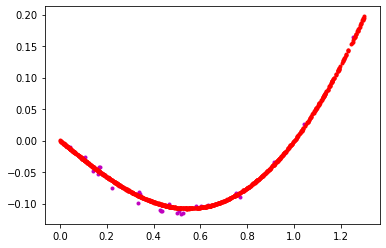

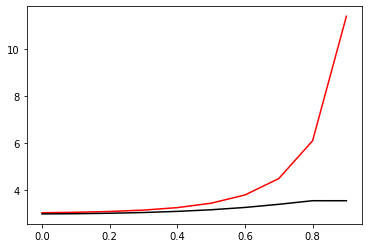

[2.977282, 2.9862046, 3.0054576, 3.0371902, 3.0849144, 3.154081, 3.2521925, 3.3855636, 3.5387988, 3.5380175]
601 tensor(0.0004)
602 tensor(0.0004)
603 tensor(0.0004)
604 tensor(0.0004)
605 tensor(0.0005)
606 tensor(0.0004)
607 tensor(0.0005)
608 tensor(0.0005)
609 tensor(0.0004)
610 tensor(0.0004)
611 tensor(0.0004)
612 tensor(0.0004)
613 tensor(0.0004)
614 tensor(0.0004)
615 tensor(0.0004)
616 tensor(0.0004)
617 tensor(0.0004)
618 tensor(0.0004)
619 tensor(0.0005)
620 tensor(0.0004)
621 tensor(0.0005)
622 tensor(0.0004)
623 tensor(0.0005)
624 tensor(0.0005)
625 tensor(0.0004)
626 tensor(0.0004)
627 tensor(0.0004)
628 tensor(0.0004)
629 tensor(0.0004)
630 tensor(0.0004)
631 tensor(0.0004)
632 tensor(0.0004)
633 tensor(0.0004)
634 tensor(0.0005)
635 tensor(0.0004)
636 tensor(0.0004)
637 tensor(0.0004)
638 tensor(0.0004)
639 tensor(0.0004)
640 tensor(0.0004)
641 tensor(0.0005)
642 tensor(0.0005)
643 tensor(0.0005)
644 tensor(0.0004)
645 tensor(0.0004)
646 tensor(0.0005)
647 tensor(0.0005

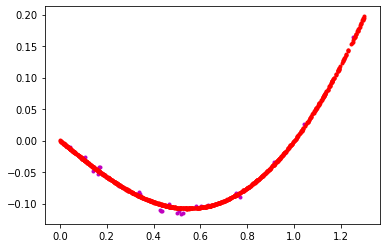

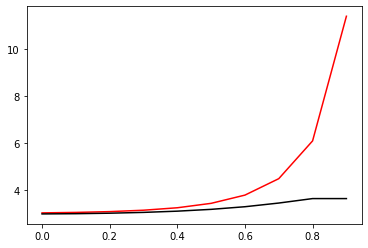

[2.9830594, 2.9928062, 3.0135098, 3.0478225, 3.1001205, 3.17711, 3.28849, 3.4447832, 3.6345139, 3.6340337]
701 tensor(0.0005)
702 tensor(0.0004)
703 tensor(0.0004)
704 tensor(0.0004)
705 tensor(0.0005)
706 tensor(0.0005)
707 tensor(0.0004)
708 tensor(0.0004)
709 tensor(0.0004)
710 tensor(0.0005)
711 tensor(0.0005)
712 tensor(0.0004)
713 tensor(0.0005)
714 tensor(0.0004)
715 tensor(0.0004)
716 tensor(0.0004)
717 tensor(0.0005)
718 tensor(0.0004)
719 tensor(0.0004)
720 tensor(0.0004)
721 tensor(0.0004)
722 tensor(0.0004)
723 tensor(0.0005)
724 tensor(0.0004)
725 tensor(0.0004)
726 tensor(0.0004)
727 tensor(0.0005)
728 tensor(0.0005)
729 tensor(0.0004)
730 tensor(0.0004)
731 tensor(0.0004)
732 tensor(0.0004)
733 tensor(0.0004)
734 tensor(0.0004)
735 tensor(0.0004)
736 tensor(0.0004)
737 tensor(0.0005)
738 tensor(0.0004)
739 tensor(0.0005)
740 tensor(0.0005)
741 tensor(0.0006)
742 tensor(0.0004)
743 tensor(0.0005)
744 tensor(0.0004)
745 tensor(0.0004)
746 tensor(0.0004)
747 tensor(0.0004)


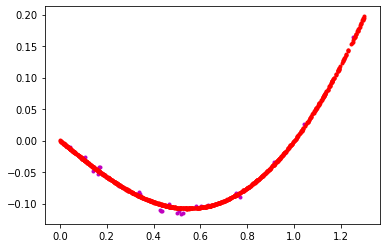

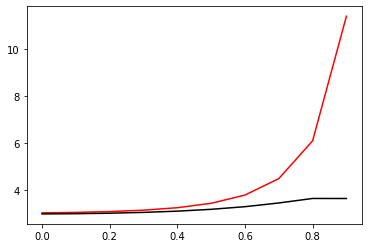

[2.9811292, 2.9907346, 3.0114822, 3.0460489, 3.0987577, 3.1763139, 3.2884896, 3.4460804, 3.6378045, 3.636074]
801 tensor(0.0004)
802 tensor(0.0004)
803 tensor(0.0004)
804 tensor(0.0004)
805 tensor(0.0004)
806 tensor(0.0005)
807 tensor(0.0004)
808 tensor(0.0004)
809 tensor(0.0004)
810 tensor(0.0005)
811 tensor(0.0004)
812 tensor(0.0004)
813 tensor(0.0004)
814 tensor(0.0004)
815 tensor(0.0004)
816 tensor(0.0005)
817 tensor(0.0004)
818 tensor(0.0004)
819 tensor(0.0004)
820 tensor(0.0004)
821 tensor(0.0004)
822 tensor(0.0004)
823 tensor(0.0004)
824 tensor(0.0004)
825 tensor(0.0005)
826 tensor(0.0005)
827 tensor(0.0004)
828 tensor(0.0004)
829 tensor(0.0004)
830 tensor(0.0004)
831 tensor(0.0004)
832 tensor(0.0004)
833 tensor(0.0004)
834 tensor(0.0004)
835 tensor(0.0004)
836 tensor(0.0004)
837 tensor(0.0005)
838 tensor(0.0005)
839 tensor(0.0005)
840 tensor(0.0005)
841 tensor(0.0005)
842 tensor(0.0004)
843 tensor(0.0004)
844 tensor(0.0004)
845 tensor(0.0004)
846 tensor(0.0005)
847 tensor(0.000

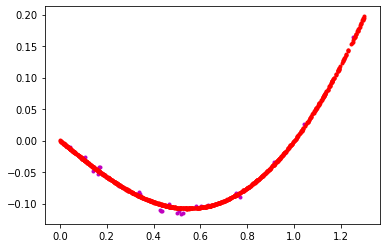

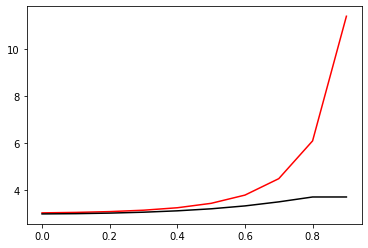

[2.9827185, 2.9936485, 3.016995, 3.0556145, 3.1141336, 3.199741, 3.3228226, 3.4945514, 3.701781, 3.7021887]
901 tensor(0.0005)
902 tensor(0.0004)
903 tensor(0.0004)
904 tensor(0.0004)
905 tensor(0.0004)
906 tensor(0.0004)
907 tensor(0.0004)
908 tensor(0.0004)
909 tensor(0.0004)
910 tensor(0.0006)
911 tensor(0.0004)
912 tensor(0.0004)
913 tensor(0.0004)
914 tensor(0.0004)
915 tensor(0.0005)
916 tensor(0.0004)
917 tensor(0.0005)
918 tensor(0.0004)
919 tensor(0.0005)
920 tensor(0.0004)
921 tensor(0.0004)
922 tensor(0.0005)
923 tensor(0.0004)
924 tensor(0.0004)
925 tensor(0.0004)
926 tensor(0.0004)
927 tensor(0.0004)
928 tensor(0.0004)
929 tensor(0.0005)
930 tensor(0.0004)
931 tensor(0.0004)
932 tensor(0.0005)
933 tensor(0.0004)
934 tensor(0.0004)
935 tensor(0.0004)
936 tensor(0.0005)
937 tensor(0.0005)
938 tensor(0.0004)
939 tensor(0.0004)
940 tensor(0.0005)
941 tensor(0.0004)
942 tensor(0.0004)
943 tensor(0.0005)
944 tensor(0.0005)
945 tensor(0.0004)
946 tensor(0.0004)
947 tensor(0.0004)

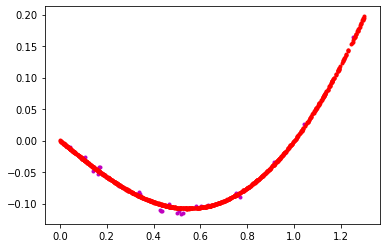

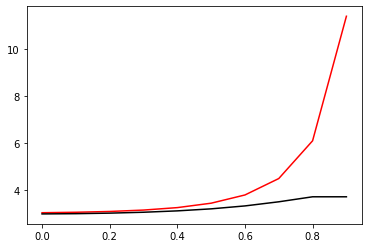

[2.976563, 2.987014, 3.0097144, 3.047747, 3.106, 3.1920018, 3.3166487, 3.4918337, 3.7046528, 3.704533]
1001 tensor(0.0005)
1002 tensor(0.0004)
1003 tensor(0.0004)
1004 tensor(0.0005)
1005 tensor(0.0004)
1006 tensor(0.0005)
1007 tensor(0.0004)
1008 tensor(0.0005)
1009 tensor(0.0005)
1010 tensor(0.0004)
1011 tensor(0.0004)
1012 tensor(0.0004)
1013 tensor(0.0004)
1014 tensor(0.0004)
1015 tensor(0.0004)
1016 tensor(0.0004)
1017 tensor(0.0004)
1018 tensor(0.0005)
1019 tensor(0.0004)
1020 tensor(0.0004)
1021 tensor(0.0004)
1022 tensor(0.0005)
1023 tensor(0.0004)
1024 tensor(0.0005)
1025 tensor(0.0005)
1026 tensor(0.0004)
1027 tensor(0.0004)
1028 tensor(0.0005)
1029 tensor(0.0004)
1030 tensor(0.0003)
1031 tensor(0.0005)
1032 tensor(0.0004)
1033 tensor(0.0004)
1034 tensor(0.0004)
1035 tensor(0.0005)
1036 tensor(0.0006)
1037 tensor(0.0004)
1038 tensor(0.0004)
1039 tensor(0.0005)
1040 tensor(0.0005)
1041 tensor(0.0004)
1042 tensor(0.0004)
1043 tensor(0.0004)
1044 tensor(0.0005)
1045 tensor(0.000

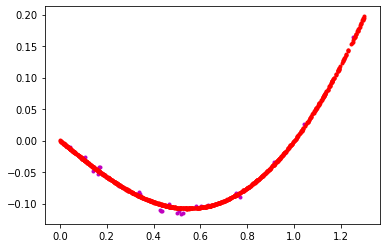

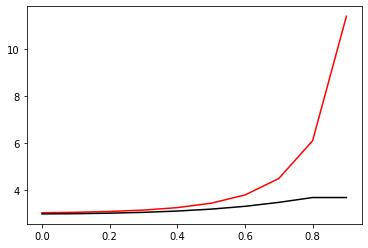

[2.977301, 2.9871352, 3.0085826, 3.0444899, 3.0995479, 3.181098, 3.2998903, 3.4679673, 3.674011, 3.6735492]
1101 tensor(0.0005)
1102 tensor(0.0004)
1103 tensor(0.0004)
1104 tensor(0.0004)
1105 tensor(0.0006)
1106 tensor(0.0004)
1107 tensor(0.0006)
1108 tensor(0.0004)
1109 tensor(0.0004)
1110 tensor(0.0004)
1111 tensor(0.0004)
1112 tensor(0.0006)
1113 tensor(0.0004)
1114 tensor(0.0004)
1115 tensor(0.0004)
1116 tensor(0.0005)
1117 tensor(0.0004)
1118 tensor(0.0004)
1119 tensor(0.0005)
1120 tensor(0.0004)
1121 tensor(0.0004)
1122 tensor(0.0004)
1123 tensor(0.0004)
1124 tensor(0.0005)
1125 tensor(0.0005)
1126 tensor(0.0005)
1127 tensor(0.0005)
1128 tensor(0.0005)
1129 tensor(0.0004)
1130 tensor(0.0004)
1131 tensor(0.0004)
1132 tensor(0.0004)
1133 tensor(0.0005)
1134 tensor(0.0004)
1135 tensor(0.0004)
1136 tensor(0.0005)
1137 tensor(0.0004)
1138 tensor(0.0004)
1139 tensor(0.0004)
1140 tensor(0.0004)
1141 tensor(0.0005)
1142 tensor(0.0004)
1143 tensor(0.0004)
1144 tensor(0.0004)
1145 tensor(

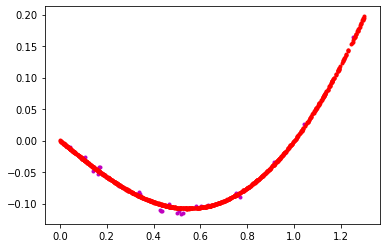

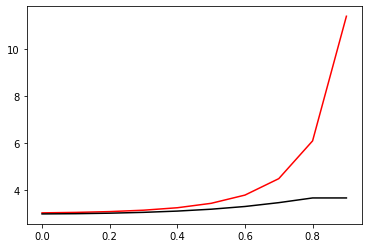

[2.9823735, 2.9922323, 3.0134642, 3.048793, 3.1027153, 3.1822844, 3.2978122, 3.4609065, 3.660662, 3.6608777]
1201 tensor(0.0005)
1202 tensor(0.0004)
1203 tensor(0.0004)
1204 tensor(0.0004)
1205 tensor(0.0004)
1206 tensor(0.0004)
1207 tensor(0.0005)
1208 tensor(0.0004)
1209 tensor(0.0005)
1210 tensor(0.0004)
1211 tensor(0.0004)
1212 tensor(0.0004)
1213 tensor(0.0005)
1214 tensor(0.0005)
1215 tensor(0.0005)
1216 tensor(0.0005)
1217 tensor(0.0005)
1218 tensor(0.0005)
1219 tensor(0.0004)
1220 tensor(0.0005)
1221 tensor(0.0004)
1222 tensor(0.0004)
1223 tensor(0.0005)
1224 tensor(0.0004)
1225 tensor(0.0004)
1226 tensor(0.0004)
1227 tensor(0.0004)
1228 tensor(0.0004)
1229 tensor(0.0004)
1230 tensor(0.0004)
1231 tensor(0.0004)
1232 tensor(0.0005)
1233 tensor(0.0004)
1234 tensor(0.0004)
1235 tensor(0.0006)
1236 tensor(0.0005)
1237 tensor(0.0004)
1238 tensor(0.0005)
1239 tensor(0.0004)
1240 tensor(0.0005)
1241 tensor(0.0005)
1242 tensor(0.0004)
1243 tensor(0.0004)
1244 tensor(0.0005)
1245 tensor

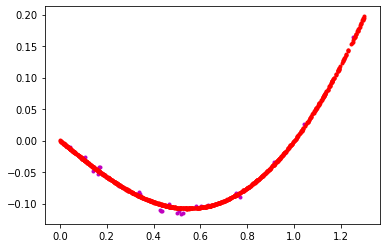

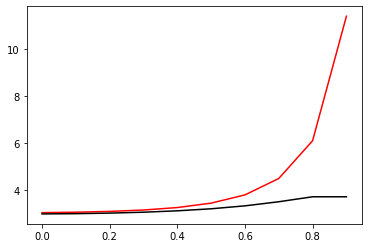

[2.9738667, 2.984591, 3.007931, 3.046713, 3.1056345, 3.1920938, 3.3168464, 3.4915156, 3.702792, 3.7021918]
1301 tensor(0.0004)
1302 tensor(0.0004)
1303 tensor(0.0005)
1304 tensor(0.0004)
1305 tensor(0.0004)
1306 tensor(0.0004)
1307 tensor(0.0005)
1308 tensor(0.0005)
1309 tensor(0.0005)
1310 tensor(0.0004)
1311 tensor(0.0004)
1312 tensor(0.0005)
1313 tensor(0.0004)
1314 tensor(0.0004)
1315 tensor(0.0004)
1316 tensor(0.0005)
1317 tensor(0.0005)
1318 tensor(0.0005)
1319 tensor(0.0004)
1320 tensor(0.0004)
1321 tensor(0.0003)
1322 tensor(0.0004)
1323 tensor(0.0004)
1324 tensor(0.0004)
1325 tensor(0.0004)
1326 tensor(0.0005)
1327 tensor(0.0004)
1328 tensor(0.0004)
1329 tensor(0.0005)
1330 tensor(0.0004)
1331 tensor(0.0004)
1332 tensor(0.0004)
1333 tensor(0.0004)
1334 tensor(0.0004)
1335 tensor(0.0004)
1336 tensor(0.0004)
1337 tensor(0.0004)
1338 tensor(0.0005)
1339 tensor(0.0004)
1340 tensor(0.0004)
1341 tensor(0.0005)
1342 tensor(0.0005)
1343 tensor(0.0004)
1344 tensor(0.0004)
1345 tensor(0

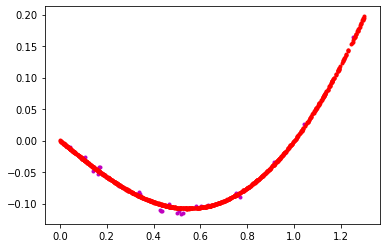

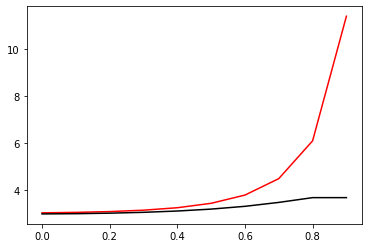

[2.9816134, 2.9915738, 3.0132048, 3.049371, 3.1046479, 3.1861782, 3.3043635, 3.4706259, 3.6730766, 3.6734788]
1401 tensor(0.0003)
1402 tensor(0.0004)
1403 tensor(0.0005)
1404 tensor(0.0004)
1405 tensor(0.0004)
1406 tensor(0.0005)
1407 tensor(0.0004)
1408 tensor(0.0004)
1409 tensor(0.0005)
1410 tensor(0.0004)
1411 tensor(0.0004)
1412 tensor(0.0005)
1413 tensor(0.0004)
1414 tensor(0.0004)
1415 tensor(0.0005)
1416 tensor(0.0004)
1417 tensor(0.0004)
1418 tensor(0.0004)
1419 tensor(0.0004)
1420 tensor(0.0004)
1421 tensor(0.0005)
1422 tensor(0.0004)
1423 tensor(0.0004)
1424 tensor(0.0004)
1425 tensor(0.0004)
1426 tensor(0.0004)
1427 tensor(0.0005)
1428 tensor(0.0004)
1429 tensor(0.0004)
1430 tensor(0.0005)
1431 tensor(0.0003)
1432 tensor(0.0004)
1433 tensor(0.0004)
1434 tensor(0.0003)
1435 tensor(0.0005)
1436 tensor(0.0004)
1437 tensor(0.0004)
1438 tensor(0.0004)
1439 tensor(0.0004)
1440 tensor(0.0004)
1441 tensor(0.0004)
1442 tensor(0.0004)
1443 tensor(0.0005)
1444 tensor(0.0004)
1445 tenso

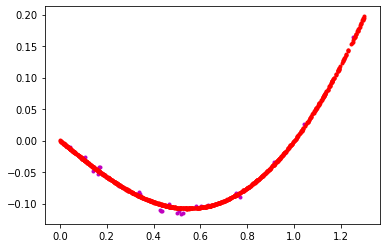

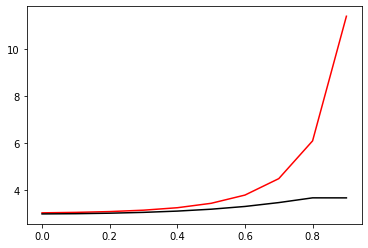

[2.981565, 2.9911764, 3.0121596, 3.0474024, 3.1015136, 3.1816688, 3.2983265, 3.4630854, 3.664358, 3.6631293]
1501 tensor(0.0004)
1502 tensor(0.0004)
1503 tensor(0.0004)
1504 tensor(0.0005)
1505 tensor(0.0004)
1506 tensor(0.0004)
1507 tensor(0.0004)
1508 tensor(0.0004)
1509 tensor(0.0005)
1510 tensor(0.0005)
1511 tensor(0.0004)
1512 tensor(0.0005)
1513 tensor(0.0004)
1514 tensor(0.0004)
1515 tensor(0.0004)
1516 tensor(0.0004)
1517 tensor(0.0004)
1518 tensor(0.0004)
1519 tensor(0.0005)
1520 tensor(0.0005)
1521 tensor(0.0003)
1522 tensor(0.0004)
1523 tensor(0.0004)
1524 tensor(0.0004)
1525 tensor(0.0005)
1526 tensor(0.0005)
1527 tensor(0.0005)
1528 tensor(0.0004)
1529 tensor(0.0004)
1530 tensor(0.0004)
1531 tensor(0.0004)
1532 tensor(0.0004)
1533 tensor(0.0004)
1534 tensor(0.0004)
1535 tensor(0.0004)
1536 tensor(0.0005)
1537 tensor(0.0004)
1538 tensor(0.0004)
1539 tensor(0.0003)
1540 tensor(0.0004)
1541 tensor(0.0005)
1542 tensor(0.0004)
1543 tensor(0.0004)
1544 tensor(0.0004)
1545 tensor

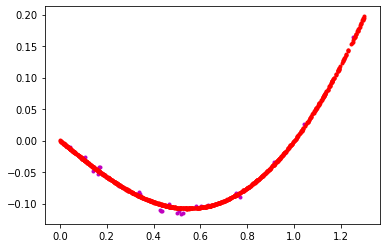

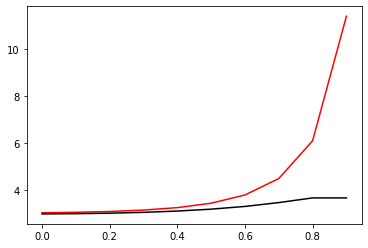

[2.9776044, 2.9875023, 3.008871, 3.0446115, 3.099221, 3.1796126, 3.295863, 3.4591513, 3.65769, 3.6576352]
1601 tensor(0.0005)
1602 tensor(0.0005)
1603 tensor(0.0005)
1604 tensor(0.0004)
1605 tensor(0.0004)
1606 tensor(0.0005)
1607 tensor(0.0005)
1608 tensor(0.0004)
1609 tensor(0.0004)
1610 tensor(0.0004)
1611 tensor(0.0005)
1612 tensor(0.0004)
1613 tensor(0.0004)
1614 tensor(0.0004)
1615 tensor(0.0005)
1616 tensor(0.0004)
1617 tensor(0.0005)
1618 tensor(0.0004)
1619 tensor(0.0004)
1620 tensor(0.0005)
1621 tensor(0.0004)
1622 tensor(0.0005)
1623 tensor(0.0004)
1624 tensor(0.0004)
1625 tensor(0.0004)
1626 tensor(0.0004)
1627 tensor(0.0004)
1628 tensor(0.0005)
1629 tensor(0.0005)
1630 tensor(0.0005)
1631 tensor(0.0004)
1632 tensor(0.0004)
1633 tensor(0.0004)
1634 tensor(0.0005)
1635 tensor(0.0004)
1636 tensor(0.0004)
1637 tensor(0.0004)
1638 tensor(0.0004)
1639 tensor(0.0005)
1640 tensor(0.0004)
1641 tensor(0.0004)
1642 tensor(0.0004)
1643 tensor(0.0003)
1644 tensor(0.0006)
1645 tensor(0.

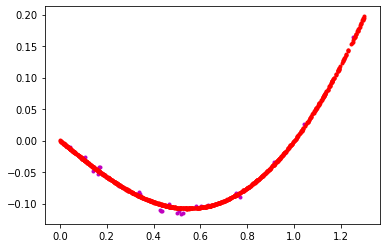

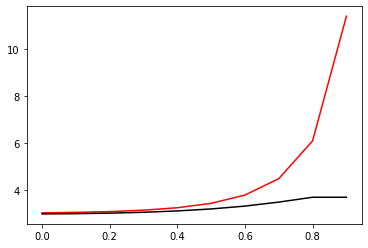

[2.981752, 2.9921308, 3.0145562, 3.0519145, 3.1088827, 3.192719, 3.3139367, 3.4839208, 3.6900284, 3.6899207]
1701 tensor(0.0004)
1702 tensor(0.0005)
1703 tensor(0.0004)
1704 tensor(0.0004)
1705 tensor(0.0004)
1706 tensor(0.0004)
1707 tensor(0.0004)
1708 tensor(0.0004)
1709 tensor(0.0004)
1710 tensor(0.0005)
1711 tensor(0.0004)
1712 tensor(0.0004)
1713 tensor(0.0004)
1714 tensor(0.0004)
1715 tensor(0.0004)
1716 tensor(0.0004)
1717 tensor(0.0004)
1718 tensor(0.0004)
1719 tensor(0.0004)
1720 tensor(0.0004)
1721 tensor(0.0004)
1722 tensor(0.0005)
1723 tensor(0.0004)
1724 tensor(0.0004)
1725 tensor(0.0004)
1726 tensor(0.0004)
1727 tensor(0.0004)
1728 tensor(0.0004)
1729 tensor(0.0004)
1730 tensor(0.0005)
1731 tensor(0.0004)
1732 tensor(0.0004)
1733 tensor(0.0004)
1734 tensor(0.0004)
1735 tensor(0.0004)
1736 tensor(0.0003)
1737 tensor(0.0005)
1738 tensor(0.0005)
1739 tensor(0.0005)
1740 tensor(0.0004)
1741 tensor(0.0004)
1742 tensor(0.0005)
1743 tensor(0.0004)
1744 tensor(0.0004)
1745 tensor

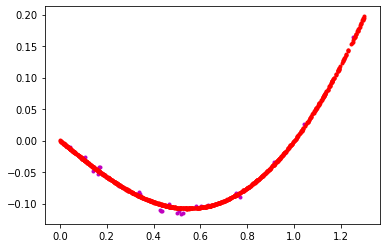

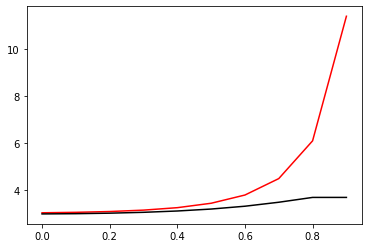

[2.9791622, 2.9891422, 3.010849, 3.0473206, 3.103317, 3.1861274, 3.3062768, 3.4752266, 3.6804187, 3.680606]
1801 tensor(0.0004)
1802 tensor(0.0005)
1803 tensor(0.0004)
1804 tensor(0.0004)
1805 tensor(0.0004)
1806 tensor(0.0004)
1807 tensor(0.0005)
1808 tensor(0.0004)
1809 tensor(0.0004)
1810 tensor(0.0004)
1811 tensor(0.0004)
1812 tensor(0.0004)
1813 tensor(0.0005)
1814 tensor(0.0005)
1815 tensor(0.0004)
1816 tensor(0.0005)
1817 tensor(0.0004)
1818 tensor(0.0004)
1819 tensor(0.0005)
1820 tensor(0.0004)
1821 tensor(0.0004)
1822 tensor(0.0004)
1823 tensor(0.0004)
1824 tensor(0.0004)
1825 tensor(0.0004)
1826 tensor(0.0004)
1827 tensor(0.0004)
1828 tensor(0.0004)
1829 tensor(0.0005)
1830 tensor(0.0004)
1831 tensor(0.0006)
1832 tensor(0.0004)
1833 tensor(0.0004)
1834 tensor(0.0005)
1835 tensor(0.0004)
1836 tensor(0.0005)
1837 tensor(0.0005)
1838 tensor(0.0004)
1839 tensor(0.0004)
1840 tensor(0.0004)
1841 tensor(0.0004)
1842 tensor(0.0004)
1843 tensor(0.0004)
1844 tensor(0.0004)
1845 tensor(

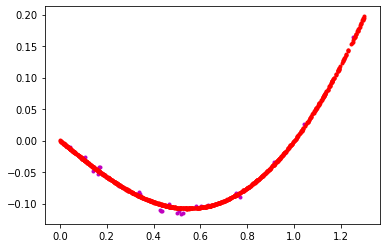

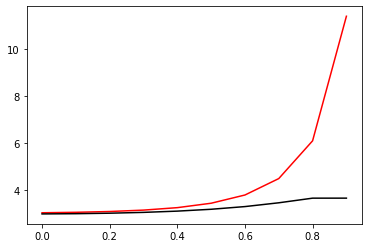

[2.97823, 2.987926, 3.008772, 3.0436075, 3.096939, 3.17568, 3.2899218, 3.4510305, 3.647989, 3.6485293]
1901 tensor(0.0004)
1902 tensor(0.0004)
1903 tensor(0.0004)
1904 tensor(0.0004)
1905 tensor(0.0005)
1906 tensor(0.0004)
1907 tensor(0.0004)
1908 tensor(0.0005)
1909 tensor(0.0004)
1910 tensor(0.0005)
1911 tensor(0.0004)
1912 tensor(0.0003)
1913 tensor(0.0005)
1914 tensor(0.0004)
1915 tensor(0.0004)
1916 tensor(0.0004)
1917 tensor(0.0005)
1918 tensor(0.0004)
1919 tensor(0.0005)
1920 tensor(0.0006)
1921 tensor(0.0004)
1922 tensor(0.0004)
1923 tensor(0.0005)
1924 tensor(0.0004)
1925 tensor(0.0005)
1926 tensor(0.0005)
1927 tensor(0.0004)
1928 tensor(0.0004)
1929 tensor(0.0004)
1930 tensor(0.0004)
1931 tensor(0.0005)
1932 tensor(0.0004)
1933 tensor(0.0004)
1934 tensor(0.0005)
1935 tensor(0.0004)
1936 tensor(0.0004)
1937 tensor(0.0005)
1938 tensor(0.0005)
1939 tensor(0.0005)
1940 tensor(0.0004)
1941 tensor(0.0004)
1942 tensor(0.0005)
1943 tensor(0.0005)
1944 tensor(0.0004)
1945 tensor(0.000

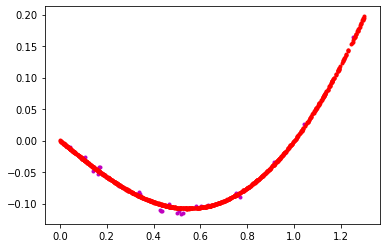

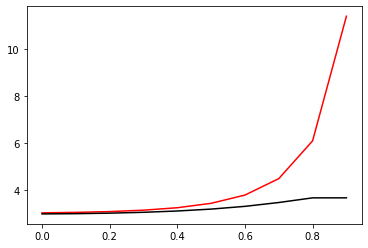

[2.9816737, 2.9919353, 3.0139325, 3.0503693, 3.1056323, 3.1865647, 3.3031168, 3.4662292, 3.6639898, 3.6642144]
2001 tensor(0.0004)
2002 tensor(0.0004)
2003 tensor(0.0004)
2004 tensor(0.0004)
2005 tensor(0.0004)
2006 tensor(0.0004)
2007 tensor(0.0005)
2008 tensor(0.0005)
2009 tensor(0.0004)
2010 tensor(0.0004)
2011 tensor(0.0004)
2012 tensor(0.0004)
2013 tensor(0.0004)
2014 tensor(0.0004)
2015 tensor(0.0005)
2016 tensor(0.0004)
2017 tensor(0.0004)
2018 tensor(0.0004)
2019 tensor(0.0004)
2020 tensor(0.0004)
2021 tensor(0.0004)
2022 tensor(0.0005)
2023 tensor(0.0005)
2024 tensor(0.0005)
2025 tensor(0.0004)
2026 tensor(0.0004)
2027 tensor(0.0004)
2028 tensor(0.0004)
2029 tensor(0.0004)
2030 tensor(0.0004)
2031 tensor(0.0004)
2032 tensor(0.0004)
2033 tensor(0.0005)
2034 tensor(0.0005)
2035 tensor(0.0004)
2036 tensor(0.0004)
2037 tensor(0.0005)
2038 tensor(0.0004)
2039 tensor(0.0004)
2040 tensor(0.0005)
2041 tensor(0.0005)
2042 tensor(0.0004)
2043 tensor(0.0004)
2044 tensor(0.0004)
2045 tens

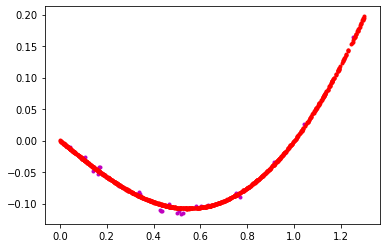

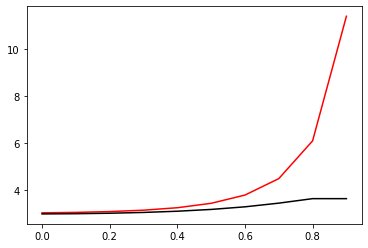

[2.981591, 2.990846, 3.010876, 3.044473, 3.0959868, 3.1721678, 3.2828875, 3.439191, 3.6303072, 3.6298652]
2101 tensor(0.0005)
2102 tensor(0.0004)
2103 tensor(0.0004)
2104 tensor(0.0004)
2105 tensor(0.0005)
2106 tensor(0.0005)
2107 tensor(0.0004)
2108 tensor(0.0004)
2109 tensor(0.0004)
2110 tensor(0.0004)
2111 tensor(0.0004)
2112 tensor(0.0004)
2113 tensor(0.0004)
2114 tensor(0.0004)
2115 tensor(0.0005)
2116 tensor(0.0004)
2117 tensor(0.0004)
2118 tensor(0.0004)
2119 tensor(0.0004)
2120 tensor(0.0004)
2121 tensor(0.0004)
2122 tensor(0.0004)
2123 tensor(0.0005)
2124 tensor(0.0004)
2125 tensor(0.0005)
2126 tensor(0.0004)
2127 tensor(0.0004)
2128 tensor(0.0004)
2129 tensor(0.0005)
2130 tensor(0.0004)
2131 tensor(0.0004)
2132 tensor(0.0004)
2133 tensor(0.0004)
2134 tensor(0.0004)
2135 tensor(0.0004)
2136 tensor(0.0004)
2137 tensor(0.0003)
2138 tensor(0.0004)
2139 tensor(0.0005)
2140 tensor(0.0004)
2141 tensor(0.0005)
2142 tensor(0.0004)
2143 tensor(0.0004)
2144 tensor(0.0004)
2145 tensor(0.

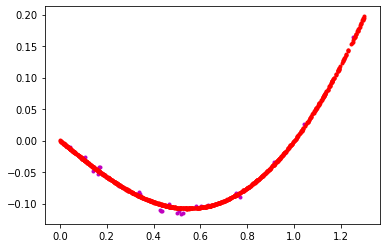

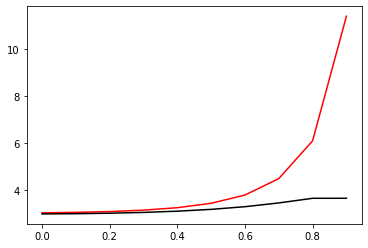

[2.980417, 2.989827, 3.0102186, 3.0443594, 3.096687, 3.1741724, 3.2870939, 3.4471955, 3.6441526, 3.6450775]
2201 tensor(0.0005)
2202 tensor(0.0005)
2203 tensor(0.0004)
2204 tensor(0.0004)
2205 tensor(0.0004)
2206 tensor(0.0004)
2207 tensor(0.0005)
2208 tensor(0.0004)
2209 tensor(0.0003)
2210 tensor(0.0005)
2211 tensor(0.0004)
2212 tensor(0.0005)
2213 tensor(0.0004)
2214 tensor(0.0004)
2215 tensor(0.0005)
2216 tensor(0.0004)
2217 tensor(0.0005)
2218 tensor(0.0004)
2219 tensor(0.0006)
2220 tensor(0.0004)
2221 tensor(0.0004)
2222 tensor(0.0004)
2223 tensor(0.0004)
2224 tensor(0.0004)
2225 tensor(0.0004)
2226 tensor(0.0004)
2227 tensor(0.0004)
2228 tensor(0.0004)
2229 tensor(0.0004)
2230 tensor(0.0004)
2231 tensor(0.0004)
2232 tensor(0.0005)
2233 tensor(0.0004)
2234 tensor(0.0005)
2235 tensor(0.0004)
2236 tensor(0.0004)
2237 tensor(0.0004)
2238 tensor(0.0004)
2239 tensor(0.0005)
2240 tensor(0.0004)
2241 tensor(0.0005)
2242 tensor(0.0005)
2243 tensor(0.0004)
2244 tensor(0.0004)
2245 tensor(

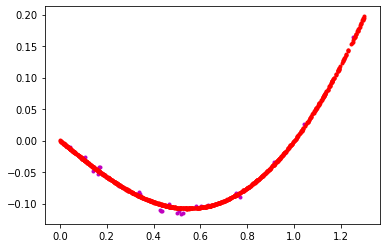

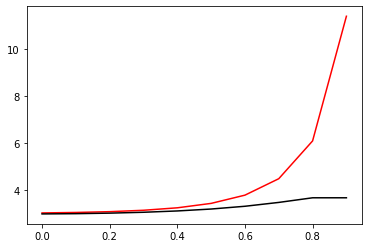

[2.9851348, 2.9957147, 3.0182378, 3.055244, 3.1111135, 3.192745, 3.310005, 3.4733112, 3.6700337, 3.6702886]
2301 tensor(0.0004)
2302 tensor(0.0004)
2303 tensor(0.0005)
2304 tensor(0.0004)
2305 tensor(0.0004)
2306 tensor(0.0004)
2307 tensor(0.0004)
2308 tensor(0.0004)
2309 tensor(0.0004)
2310 tensor(0.0004)
2311 tensor(0.0004)
2312 tensor(0.0004)
2313 tensor(0.0004)
2314 tensor(0.0004)
2315 tensor(0.0005)
2316 tensor(0.0004)
2317 tensor(0.0004)
2318 tensor(0.0004)
2319 tensor(0.0004)
2320 tensor(0.0005)
2321 tensor(0.0004)
2322 tensor(0.0005)
2323 tensor(0.0004)
2324 tensor(0.0004)
2325 tensor(0.0004)
2326 tensor(0.0005)
2327 tensor(0.0004)
2328 tensor(0.0005)
2329 tensor(0.0005)
2330 tensor(0.0004)
2331 tensor(0.0005)
2332 tensor(0.0004)
2333 tensor(0.0004)
2334 tensor(0.0004)
2335 tensor(0.0004)
2336 tensor(0.0004)
2337 tensor(0.0004)
2338 tensor(0.0004)
2339 tensor(0.0004)
2340 tensor(0.0004)
2341 tensor(0.0004)
2342 tensor(0.0005)
2343 tensor(0.0004)
2344 tensor(0.0004)
2345 tensor(

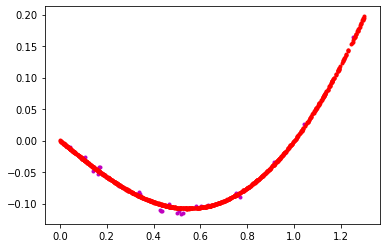

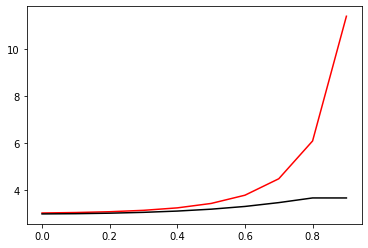

[2.9878871, 2.9977424, 3.0190701, 3.0546484, 3.1089802, 3.1890204, 3.3048851, 3.4677835, 3.6661615, 3.6652606]
2401 tensor(0.0004)
2402 tensor(0.0004)
2403 tensor(0.0005)
2404 tensor(0.0004)
2405 tensor(0.0004)
2406 tensor(0.0004)
2407 tensor(0.0004)
2408 tensor(0.0004)
2409 tensor(0.0004)
2410 tensor(0.0004)
2411 tensor(0.0004)
2412 tensor(0.0004)
2413 tensor(0.0004)
2414 tensor(0.0004)
2415 tensor(0.0004)
2416 tensor(0.0004)
2417 tensor(0.0004)
2418 tensor(0.0004)
2419 tensor(0.0005)
2420 tensor(0.0004)
2421 tensor(0.0004)
2422 tensor(0.0006)
2423 tensor(0.0005)
2424 tensor(0.0004)
2425 tensor(0.0004)
2426 tensor(0.0004)
2427 tensor(0.0004)
2428 tensor(0.0004)
2429 tensor(0.0004)
2430 tensor(0.0005)
2431 tensor(0.0005)
2432 tensor(0.0004)
2433 tensor(0.0004)
2434 tensor(0.0004)
2435 tensor(0.0004)
2436 tensor(0.0005)
2437 tensor(0.0004)
2438 tensor(0.0004)
2439 tensor(0.0004)
2440 tensor(0.0004)
2441 tensor(0.0004)
2442 tensor(0.0005)
2443 tensor(0.0004)
2444 tensor(0.0005)
2445 tens

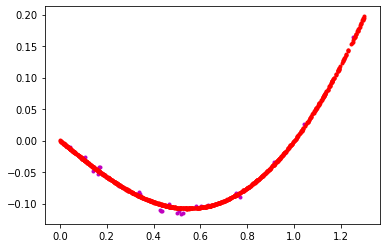

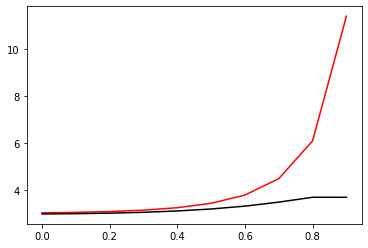

[2.9807217, 2.9907722, 3.012857, 3.0499063, 3.106597, 3.1902153, 3.3113327, 3.4814425, 3.6880279, 3.687554]
2501 tensor(0.0004)
2502 tensor(0.0004)
2503 tensor(0.0005)
2504 tensor(0.0004)
2505 tensor(0.0005)
2506 tensor(0.0004)
2507 tensor(0.0004)
2508 tensor(0.0005)
2509 tensor(0.0004)
2510 tensor(0.0004)
2511 tensor(0.0004)
2512 tensor(0.0004)
2513 tensor(0.0004)
2514 tensor(0.0004)
2515 tensor(0.0004)
2516 tensor(0.0004)
2517 tensor(0.0004)
2518 tensor(0.0004)
2519 tensor(0.0004)
2520 tensor(0.0004)
2521 tensor(0.0004)
2522 tensor(0.0004)
2523 tensor(0.0004)
2524 tensor(0.0004)
2525 tensor(0.0004)
2526 tensor(0.0005)
2527 tensor(0.0004)
2528 tensor(0.0004)
2529 tensor(0.0005)
2530 tensor(0.0004)
2531 tensor(0.0004)
2532 tensor(0.0004)
2533 tensor(0.0004)
2534 tensor(0.0004)
2535 tensor(0.0005)
2536 tensor(0.0004)
2537 tensor(0.0004)
2538 tensor(0.0005)
2539 tensor(0.0005)
2540 tensor(0.0005)
2541 tensor(0.0005)
2542 tensor(0.0004)
2543 tensor(0.0005)
2544 tensor(0.0004)
2545 tensor(

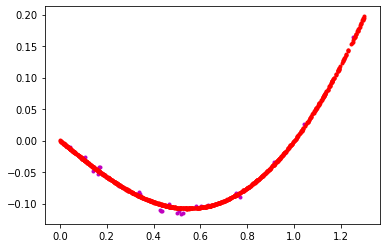

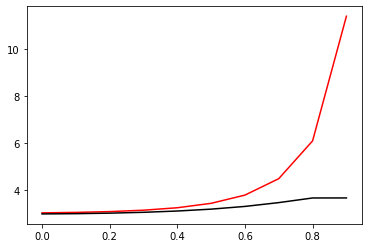

[2.9824681, 2.9929984, 3.0149658, 3.0509925, 3.1055236, 3.1854758, 3.3008952, 3.4628186, 3.6598349, 3.6608655]
2601 tensor(0.0005)
2602 tensor(0.0004)
2603 tensor(0.0004)
2604 tensor(0.0005)
2605 tensor(0.0004)
2606 tensor(0.0005)
2607 tensor(0.0005)
2608 tensor(0.0005)
2609 tensor(0.0004)
2610 tensor(0.0005)
2611 tensor(0.0004)
2612 tensor(0.0005)
2613 tensor(0.0004)
2614 tensor(0.0004)
2615 tensor(0.0004)
2616 tensor(0.0004)
2617 tensor(0.0005)
2618 tensor(0.0006)
2619 tensor(0.0004)
2620 tensor(0.0005)
2621 tensor(0.0004)
2622 tensor(0.0005)
2623 tensor(0.0004)
2624 tensor(0.0005)
2625 tensor(0.0004)
2626 tensor(0.0004)
2627 tensor(0.0004)
2628 tensor(0.0005)
2629 tensor(0.0005)
2630 tensor(0.0005)
2631 tensor(0.0004)
2632 tensor(0.0005)
2633 tensor(0.0005)
2634 tensor(0.0004)
2635 tensor(0.0005)
2636 tensor(0.0004)
2637 tensor(0.0004)
2638 tensor(0.0004)
2639 tensor(0.0005)
2640 tensor(0.0004)
2641 tensor(0.0005)
2642 tensor(0.0005)
2643 tensor(0.0004)
2644 tensor(0.0004)
2645 tens

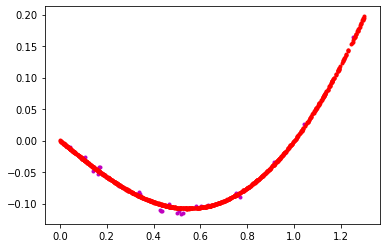

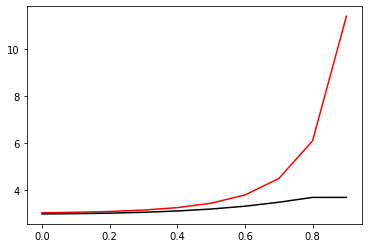

[2.9772243, 2.9876184, 3.0098193, 3.0465817, 3.1025598, 3.1850464, 3.3046906, 3.47329, 3.679024, 3.6796408]
2701 tensor(0.0004)
2702 tensor(0.0005)
2703 tensor(0.0005)
2704 tensor(0.0004)
2705 tensor(0.0004)
2706 tensor(0.0005)
2707 tensor(0.0004)
2708 tensor(0.0004)
2709 tensor(0.0005)
2710 tensor(0.0004)
2711 tensor(0.0004)
2712 tensor(0.0004)
2713 tensor(0.0004)
2714 tensor(0.0005)
2715 tensor(0.0007)
2716 tensor(0.0004)
2717 tensor(0.0005)
2718 tensor(0.0004)
2719 tensor(0.0004)
2720 tensor(0.0005)
2721 tensor(0.0004)
2722 tensor(0.0005)
2723 tensor(0.0004)
2724 tensor(0.0005)
2725 tensor(0.0004)
2726 tensor(0.0005)
2727 tensor(0.0004)
2728 tensor(0.0004)
2729 tensor(0.0005)
2730 tensor(0.0004)
2731 tensor(0.0004)
2732 tensor(0.0004)
2733 tensor(0.0004)
2734 tensor(0.0005)
2735 tensor(0.0004)
2736 tensor(0.0004)
2737 tensor(0.0004)
2738 tensor(0.0005)
2739 tensor(0.0005)
2740 tensor(0.0004)
2741 tensor(0.0005)
2742 tensor(0.0004)
2743 tensor(0.0004)
2744 tensor(0.0005)
2745 tensor(

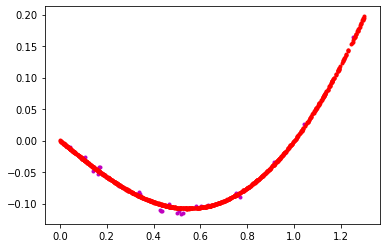

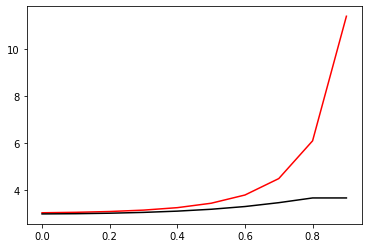

[2.9787087, 2.9881032, 3.0087285, 3.0434709, 3.0969756, 3.1764507, 3.2924163, 3.4565444, 3.6573625, 3.6574664]
2801 tensor(0.0005)
2802 tensor(0.0004)
2803 tensor(0.0004)
2804 tensor(0.0004)
2805 tensor(0.0005)
2806 tensor(0.0004)
2807 tensor(0.0005)
2808 tensor(0.0005)
2809 tensor(0.0004)
2810 tensor(0.0004)
2811 tensor(0.0004)
2812 tensor(0.0005)
2813 tensor(0.0005)
2814 tensor(0.0005)
2815 tensor(0.0005)
2816 tensor(0.0004)
2817 tensor(0.0005)
2818 tensor(0.0004)
2819 tensor(0.0004)
2820 tensor(0.0005)
2821 tensor(0.0004)
2822 tensor(0.0004)
2823 tensor(0.0004)
2824 tensor(0.0004)
2825 tensor(0.0004)
2826 tensor(0.0005)
2827 tensor(0.0004)
2828 tensor(0.0004)
2829 tensor(0.0004)
2830 tensor(0.0004)
2831 tensor(0.0004)
2832 tensor(0.0005)
2833 tensor(0.0004)
2834 tensor(0.0004)
2835 tensor(0.0004)
2836 tensor(0.0004)
2837 tensor(0.0004)
2838 tensor(0.0005)
2839 tensor(0.0004)
2840 tensor(0.0005)
2841 tensor(0.0004)
2842 tensor(0.0004)
2843 tensor(0.0005)
2844 tensor(0.0005)
2845 tens

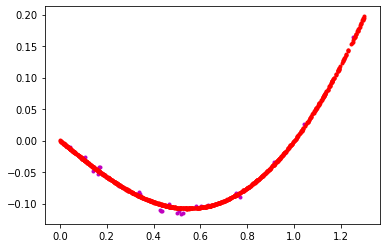

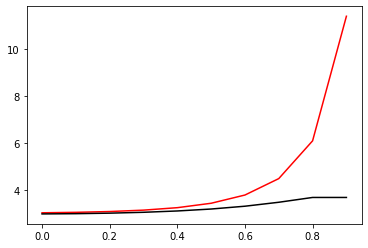

[2.979404, 2.9895964, 3.0116932, 3.0485532, 3.1047306, 3.1873353, 3.306789, 3.4746675, 3.678953, 3.6789753]
2901 tensor(0.0004)
2902 tensor(0.0004)
2903 tensor(0.0004)
2904 tensor(0.0004)
2905 tensor(0.0004)
2906 tensor(0.0004)
2907 tensor(0.0003)
2908 tensor(0.0004)
2909 tensor(0.0004)
2910 tensor(0.0005)
2911 tensor(0.0004)
2912 tensor(0.0005)
2913 tensor(0.0005)
2914 tensor(0.0004)
2915 tensor(0.0004)
2916 tensor(0.0004)
2917 tensor(0.0004)
2918 tensor(0.0004)
2919 tensor(0.0004)
2920 tensor(0.0004)
2921 tensor(0.0005)
2922 tensor(0.0004)
2923 tensor(0.0004)
2924 tensor(0.0005)
2925 tensor(0.0004)
2926 tensor(0.0004)
2927 tensor(0.0004)
2928 tensor(0.0005)
2929 tensor(0.0004)
2930 tensor(0.0005)
2931 tensor(0.0004)
2932 tensor(0.0004)
2933 tensor(0.0004)
2934 tensor(0.0005)
2935 tensor(0.0005)
2936 tensor(0.0004)
2937 tensor(0.0003)
2938 tensor(0.0004)
2939 tensor(0.0004)
2940 tensor(0.0004)
2941 tensor(0.0004)
2942 tensor(0.0005)
2943 tensor(0.0004)
2944 tensor(0.0004)
2945 tensor(

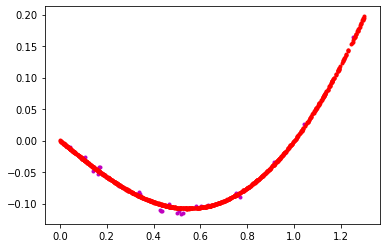

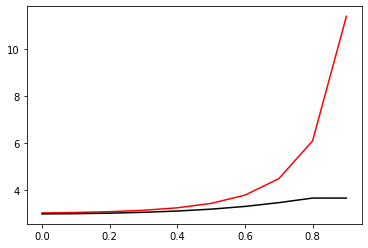

[2.9855728, 2.9957142, 3.0175004, 3.0535874, 3.108277, 3.1882427, 3.3031938, 3.4637752, 3.6583319, 3.6577628]
3001 tensor(0.0004)
3002 tensor(0.0006)
3003 tensor(0.0005)
3004 tensor(0.0004)
3005 tensor(0.0004)
3006 tensor(0.0005)
3007 tensor(0.0004)
3008 tensor(0.0004)
3009 tensor(0.0004)
3010 tensor(0.0004)
3011 tensor(0.0005)
3012 tensor(0.0004)
3013 tensor(0.0004)
3014 tensor(0.0004)
3015 tensor(0.0004)
3016 tensor(0.0004)
3017 tensor(0.0005)
3018 tensor(0.0004)
3019 tensor(0.0004)
3020 tensor(0.0004)
3021 tensor(0.0004)
3022 tensor(0.0004)
3023 tensor(0.0005)
3024 tensor(0.0004)
3025 tensor(0.0004)
3026 tensor(0.0005)
3027 tensor(0.0004)
3028 tensor(0.0004)
3029 tensor(0.0004)
3030 tensor(0.0005)
3031 tensor(0.0004)
3032 tensor(0.0005)
3033 tensor(0.0004)
3034 tensor(0.0004)
3035 tensor(0.0004)
3036 tensor(0.0005)
3037 tensor(0.0005)
3038 tensor(0.0005)
3039 tensor(0.0004)
3040 tensor(0.0004)
3041 tensor(0.0005)
3042 tensor(0.0005)
3043 tensor(0.0004)
3044 tensor(0.0004)
3045 tenso

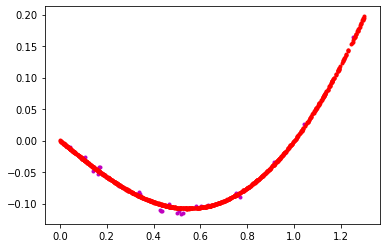

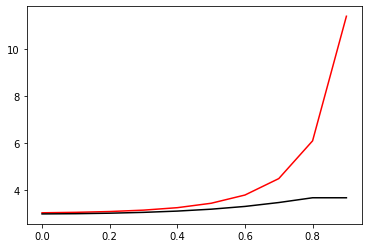

[2.9795625, 2.9891334, 3.0101404, 3.0455027, 3.0998514, 3.1803813, 3.2976203, 3.463363, 3.6661177, 3.66559]
3101 tensor(0.0004)
3102 tensor(0.0005)
3103 tensor(0.0004)
3104 tensor(0.0004)
3105 tensor(0.0004)
3106 tensor(0.0005)
3107 tensor(0.0004)
3108 tensor(0.0004)
3109 tensor(0.0005)
3110 tensor(0.0004)
3111 tensor(0.0004)
3112 tensor(0.0005)
3113 tensor(0.0004)
3114 tensor(0.0004)
3115 tensor(0.0004)
3116 tensor(0.0005)
3117 tensor(0.0005)
3118 tensor(0.0004)
3119 tensor(0.0004)
3120 tensor(0.0004)
3121 tensor(0.0004)
3122 tensor(0.0004)
3123 tensor(0.0004)
3124 tensor(0.0004)
3125 tensor(0.0004)
3126 tensor(0.0004)
3127 tensor(0.0004)
3128 tensor(0.0004)
3129 tensor(0.0004)
3130 tensor(0.0005)
3131 tensor(0.0004)
3132 tensor(0.0005)
3133 tensor(0.0003)
3134 tensor(0.0004)
3135 tensor(0.0004)
3136 tensor(0.0004)
3137 tensor(0.0004)
3138 tensor(0.0004)
3139 tensor(0.0004)
3140 tensor(0.0004)
3141 tensor(0.0005)
3142 tensor(0.0004)
3143 tensor(0.0005)
3144 tensor(0.0004)
3145 tensor(

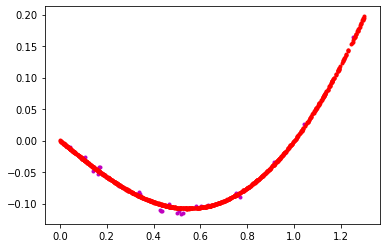

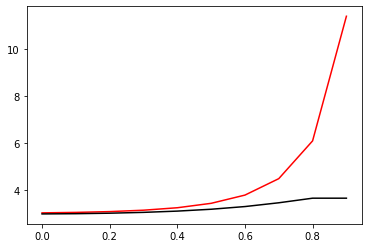

[2.9823682, 2.9920263, 3.0130322, 3.0481665, 3.101811, 3.180766, 3.2949746, 3.4554586, 3.6504948, 3.65055]
3201 tensor(0.0004)
3202 tensor(0.0004)
3203 tensor(0.0004)
3204 tensor(0.0004)
3205 tensor(0.0004)
3206 tensor(0.0005)
3207 tensor(0.0004)
3208 tensor(0.0005)
3209 tensor(0.0004)
3210 tensor(0.0004)
3211 tensor(0.0004)
3212 tensor(0.0004)
3213 tensor(0.0004)
3214 tensor(0.0004)
3215 tensor(0.0004)
3216 tensor(0.0004)
3217 tensor(0.0004)
3218 tensor(0.0005)
3219 tensor(0.0005)
3220 tensor(0.0004)
3221 tensor(0.0004)
3222 tensor(0.0004)
3223 tensor(0.0004)
3224 tensor(0.0005)
3225 tensor(0.0004)
3226 tensor(0.0004)
3227 tensor(0.0004)
3228 tensor(0.0004)
3229 tensor(0.0005)
3230 tensor(0.0004)
3231 tensor(0.0005)
3232 tensor(0.0004)
3233 tensor(0.0004)
3234 tensor(0.0004)
3235 tensor(0.0004)
3236 tensor(0.0004)
3237 tensor(0.0004)
3238 tensor(0.0005)
3239 tensor(0.0004)
3240 tensor(0.0004)
3241 tensor(0.0004)
3242 tensor(0.0004)
3243 tensor(0.0004)
3244 tensor(0.0005)
3245 tensor(0

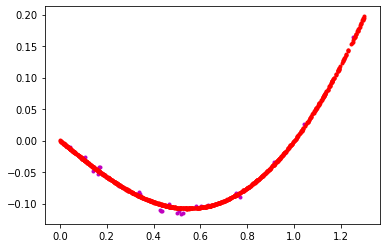

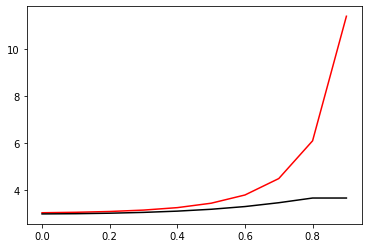

[2.9776485, 2.9871202, 3.0078135, 3.0425806, 3.0959916, 3.1751506, 3.2904491, 3.4535215, 3.6530364, 3.6528337]
3301 tensor(0.0005)
3302 tensor(0.0004)
3303 tensor(0.0004)
3304 tensor(0.0004)
3305 tensor(0.0004)
3306 tensor(0.0004)
3307 tensor(0.0004)
3308 tensor(0.0005)
3309 tensor(0.0005)
3310 tensor(0.0004)
3311 tensor(0.0004)
3312 tensor(0.0005)
3313 tensor(0.0004)
3314 tensor(0.0004)
3315 tensor(0.0005)
3316 tensor(0.0004)
3317 tensor(0.0005)
3318 tensor(0.0004)
3319 tensor(0.0004)
3320 tensor(0.0004)
3321 tensor(0.0004)
3322 tensor(0.0004)
3323 tensor(0.0004)
3324 tensor(0.0004)
3325 tensor(0.0004)
3326 tensor(0.0004)
3327 tensor(0.0005)
3328 tensor(0.0004)
3329 tensor(0.0004)
3330 tensor(0.0005)
3331 tensor(0.0005)
3332 tensor(0.0004)
3333 tensor(0.0004)
3334 tensor(0.0004)
3335 tensor(0.0004)
3336 tensor(0.0004)
3337 tensor(0.0005)
3338 tensor(0.0004)
3339 tensor(0.0004)
3340 tensor(0.0004)
3341 tensor(0.0004)
3342 tensor(0.0005)
3343 tensor(0.0005)
3344 tensor(0.0005)
3345 tens

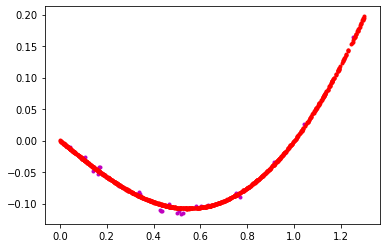

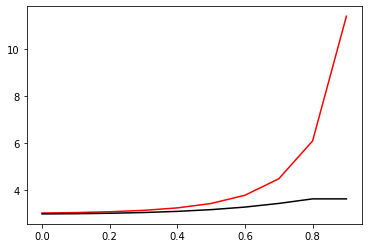

[2.9893384, 2.9978752, 3.0165873, 3.0483022, 3.0974991, 3.1711094, 3.2793725, 3.4344025, 3.6277206, 3.6278632]
3401 tensor(0.0005)
3402 tensor(0.0005)
3403 tensor(0.0005)
3404 tensor(0.0004)
3405 tensor(0.0004)
3406 tensor(0.0004)
3407 tensor(0.0004)
3408 tensor(0.0004)
3409 tensor(0.0003)
3410 tensor(0.0004)
3411 tensor(0.0004)
3412 tensor(0.0005)
3413 tensor(0.0004)
3414 tensor(0.0004)
3415 tensor(0.0004)
3416 tensor(0.0004)
3417 tensor(0.0005)
3418 tensor(0.0005)
3419 tensor(0.0005)
3420 tensor(0.0004)
3421 tensor(0.0004)
3422 tensor(0.0004)
3423 tensor(0.0004)
3424 tensor(0.0004)
3425 tensor(0.0005)
3426 tensor(0.0005)
3427 tensor(0.0005)
3428 tensor(0.0004)
3429 tensor(0.0004)
3430 tensor(0.0004)
3431 tensor(0.0004)
3432 tensor(0.0004)
3433 tensor(0.0004)
3434 tensor(0.0006)
3435 tensor(0.0004)
3436 tensor(0.0005)
3437 tensor(0.0004)
3438 tensor(0.0004)
3439 tensor(0.0005)
3440 tensor(0.0004)
3441 tensor(0.0004)
3442 tensor(0.0004)
3443 tensor(0.0004)
3444 tensor(0.0004)
3445 tens

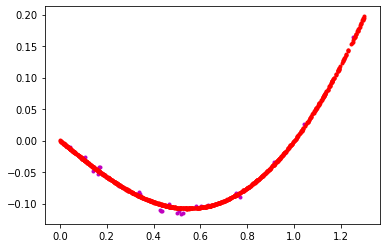

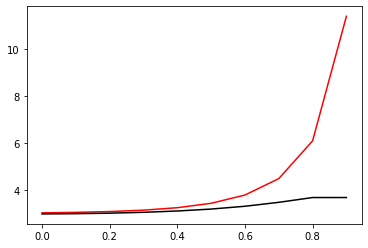

[2.9806836, 2.99082, 3.0126526, 3.0490658, 3.1047318, 3.1868358, 3.3057737, 3.4729767, 3.6762877, 3.6766331]
3501 tensor(0.0004)
3502 tensor(0.0004)
3503 tensor(0.0005)
3504 tensor(0.0004)
3505 tensor(0.0004)
3506 tensor(0.0004)
3507 tensor(0.0005)
3508 tensor(0.0005)
3509 tensor(0.0005)
3510 tensor(0.0004)
3511 tensor(0.0004)
3512 tensor(0.0005)
3513 tensor(0.0005)
3514 tensor(0.0004)
3515 tensor(0.0004)
3516 tensor(0.0004)
3517 tensor(0.0004)
3518 tensor(0.0004)
3519 tensor(0.0004)
3520 tensor(0.0005)
3521 tensor(0.0004)
3522 tensor(0.0003)
3523 tensor(0.0004)
3524 tensor(0.0004)
3525 tensor(0.0004)
3526 tensor(0.0004)
3527 tensor(0.0004)
3528 tensor(0.0004)
3529 tensor(0.0004)
3530 tensor(0.0004)
3531 tensor(0.0005)
3532 tensor(0.0004)
3533 tensor(0.0005)
3534 tensor(0.0005)
3535 tensor(0.0005)
3536 tensor(0.0004)
3537 tensor(0.0004)
3538 tensor(0.0006)
3539 tensor(0.0005)
3540 tensor(0.0005)
3541 tensor(0.0005)
3542 tensor(0.0004)
3543 tensor(0.0004)
3544 tensor(0.0005)
3545 tensor

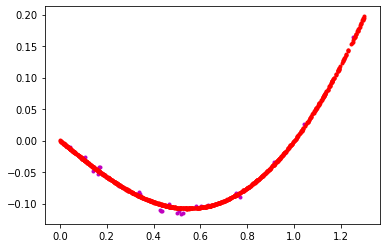

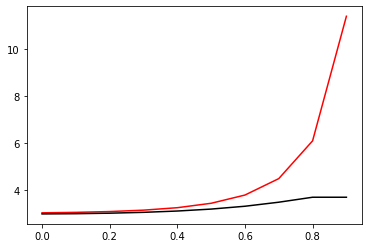

[2.9803636, 2.9901202, 3.0115504, 3.0476615, 3.1032546, 3.1858327, 3.3064902, 3.4779367, 3.689132, 3.6889043]
3601 tensor(0.0004)
3602 tensor(0.0004)
3603 tensor(0.0005)
3604 tensor(0.0006)
3605 tensor(0.0005)
3606 tensor(0.0004)
3607 tensor(0.0003)
3608 tensor(0.0004)
3609 tensor(0.0004)
3610 tensor(0.0005)
3611 tensor(0.0004)
3612 tensor(0.0005)
3613 tensor(0.0005)
3614 tensor(0.0004)
3615 tensor(0.0004)
3616 tensor(0.0004)
3617 tensor(0.0004)
3618 tensor(0.0005)
3619 tensor(0.0004)
3620 tensor(0.0005)
3621 tensor(0.0004)
3622 tensor(0.0004)
3623 tensor(0.0004)
3624 tensor(0.0004)
3625 tensor(0.0006)
3626 tensor(0.0004)
3627 tensor(0.0005)
3628 tensor(0.0005)
3629 tensor(0.0004)
3630 tensor(0.0004)
3631 tensor(0.0004)
3632 tensor(0.0004)
3633 tensor(0.0004)
3634 tensor(0.0004)
3635 tensor(0.0004)
3636 tensor(0.0005)
3637 tensor(0.0004)
3638 tensor(0.0004)
3639 tensor(0.0004)
3640 tensor(0.0004)
3641 tensor(0.0004)
3642 tensor(0.0004)
3643 tensor(0.0004)
3644 tensor(0.0004)
3645 tenso

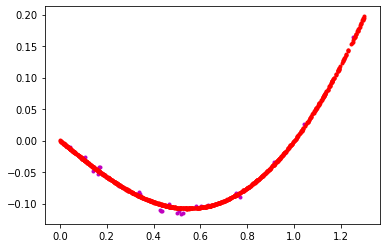

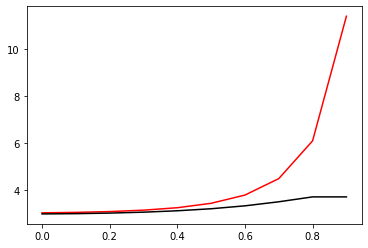

[2.981163, 2.9924362, 3.0163572, 3.0555604, 3.1146283, 3.200788, 3.324439, 3.4967074, 3.7045228, 3.7043934]
3701 tensor(0.0004)
3702 tensor(0.0005)
3703 tensor(0.0004)
3704 tensor(0.0004)
3705 tensor(0.0004)
3706 tensor(0.0005)
3707 tensor(0.0004)
3708 tensor(0.0005)
3709 tensor(0.0004)
3710 tensor(0.0004)
3711 tensor(0.0003)
3712 tensor(0.0004)
3713 tensor(0.0004)
3714 tensor(0.0005)
3715 tensor(0.0006)
3716 tensor(0.0004)
3717 tensor(0.0004)
3718 tensor(0.0004)
3719 tensor(0.0005)
3720 tensor(0.0005)
3721 tensor(0.0004)
3722 tensor(0.0004)
3723 tensor(0.0005)
3724 tensor(0.0005)
3725 tensor(0.0004)
3726 tensor(0.0005)
3727 tensor(0.0004)
3728 tensor(0.0004)
3729 tensor(0.0004)
3730 tensor(0.0004)
3731 tensor(0.0005)
3732 tensor(0.0004)
3733 tensor(0.0004)
3734 tensor(0.0005)
3735 tensor(0.0005)
3736 tensor(0.0004)
3737 tensor(0.0004)
3738 tensor(0.0004)
3739 tensor(0.0004)
3740 tensor(0.0004)
3741 tensor(0.0004)
3742 tensor(0.0005)
3743 tensor(0.0004)
3744 tensor(0.0004)
3745 tensor(

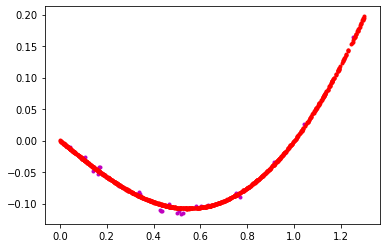

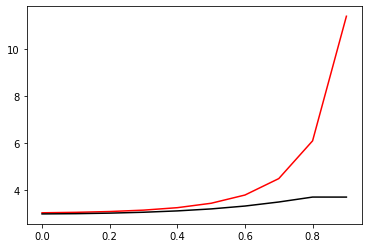

[2.9795601, 2.990132, 3.0128257, 3.050489, 3.1077936, 3.192078, 3.3141127, 3.4858937, 3.6955192, 3.6945338]
3801 tensor(0.0004)
3802 tensor(0.0004)
3803 tensor(0.0004)
3804 tensor(0.0005)
3805 tensor(0.0004)
3806 tensor(0.0004)
3807 tensor(0.0004)
3808 tensor(0.0005)
3809 tensor(0.0004)
3810 tensor(0.0004)
3811 tensor(0.0005)
3812 tensor(0.0004)
3813 tensor(0.0005)
3814 tensor(0.0005)
3815 tensor(0.0004)
3816 tensor(0.0005)
3817 tensor(0.0005)
3818 tensor(0.0004)
3819 tensor(0.0004)
3820 tensor(0.0004)
3821 tensor(0.0004)
3822 tensor(0.0004)
3823 tensor(0.0004)
3824 tensor(0.0004)
3825 tensor(0.0004)
3826 tensor(0.0004)
3827 tensor(0.0004)
3828 tensor(0.0004)
3829 tensor(0.0004)
3830 tensor(0.0005)
3831 tensor(0.0005)
3832 tensor(0.0005)
3833 tensor(0.0004)
3834 tensor(0.0005)
3835 tensor(0.0004)
3836 tensor(0.0004)
3837 tensor(0.0004)
3838 tensor(0.0004)
3839 tensor(0.0005)
3840 tensor(0.0004)
3841 tensor(0.0004)
3842 tensor(0.0004)
3843 tensor(0.0004)
3844 tensor(0.0004)
3845 tensor(

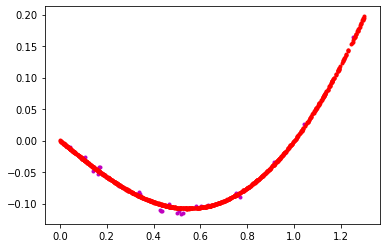

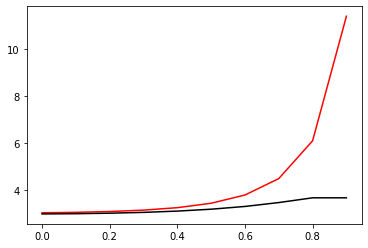

[2.9792044, 2.9887342, 3.0096812, 3.0449283, 3.099139, 3.1795123, 3.296525, 3.4617858, 3.6636007, 3.6637876]
3901 tensor(0.0004)
3902 tensor(0.0004)
3903 tensor(0.0004)
3904 tensor(0.0005)
3905 tensor(0.0004)
3906 tensor(0.0003)
3907 tensor(0.0005)
3908 tensor(0.0004)
3909 tensor(0.0003)
3910 tensor(0.0005)
3911 tensor(0.0005)
3912 tensor(0.0005)
3913 tensor(0.0004)
3914 tensor(0.0004)
3915 tensor(0.0004)
3916 tensor(0.0005)
3917 tensor(0.0003)
3918 tensor(0.0005)
3919 tensor(0.0005)
3920 tensor(0.0004)
3921 tensor(0.0005)
3922 tensor(0.0004)
3923 tensor(0.0005)
3924 tensor(0.0004)
3925 tensor(0.0004)
3926 tensor(0.0004)
3927 tensor(0.0004)
3928 tensor(0.0005)
3929 tensor(0.0005)
3930 tensor(0.0004)
3931 tensor(0.0004)
3932 tensor(0.0004)
3933 tensor(0.0004)
3934 tensor(0.0004)
3935 tensor(0.0004)
3936 tensor(0.0004)
3937 tensor(0.0004)
3938 tensor(0.0004)
3939 tensor(0.0005)
3940 tensor(0.0004)
3941 tensor(0.0004)
3942 tensor(0.0005)
3943 tensor(0.0004)
3944 tensor(0.0004)
3945 tensor

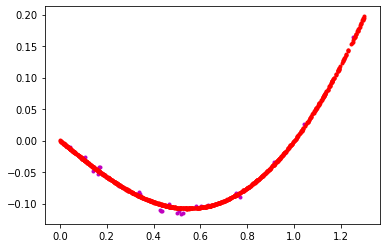

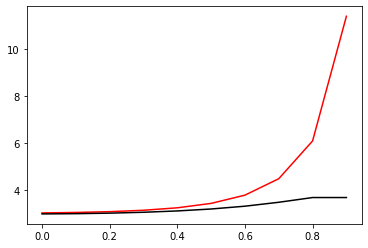

[2.9850454, 2.9954858, 3.0178807, 3.055023, 3.1114123, 3.194047, 3.3130555, 3.4793737, 3.6803894, 3.6805797]
4001 tensor(0.0004)
4002 tensor(0.0004)
4003 tensor(0.0004)
4004 tensor(0.0004)
4005 tensor(0.0004)
4006 tensor(0.0004)
4007 tensor(0.0004)
4008 tensor(0.0004)
4009 tensor(0.0005)
4010 tensor(0.0004)
4011 tensor(0.0004)
4012 tensor(0.0004)
4013 tensor(0.0004)
4014 tensor(0.0004)
4015 tensor(0.0004)
4016 tensor(0.0004)
4017 tensor(0.0004)
4018 tensor(0.0004)
4019 tensor(0.0004)
4020 tensor(0.0004)
4021 tensor(0.0005)
4022 tensor(0.0005)
4023 tensor(0.0004)
4024 tensor(0.0004)
4025 tensor(0.0005)
4026 tensor(0.0004)
4027 tensor(0.0004)
4028 tensor(0.0004)
4029 tensor(0.0005)
4030 tensor(0.0004)
4031 tensor(0.0004)
4032 tensor(0.0004)
4033 tensor(0.0004)
4034 tensor(0.0004)
4035 tensor(0.0004)
4036 tensor(0.0005)
4037 tensor(0.0004)
4038 tensor(0.0005)
4039 tensor(0.0005)
4040 tensor(0.0004)
4041 tensor(0.0004)
4042 tensor(0.0004)
4043 tensor(0.0004)
4044 tensor(0.0004)
4045 tensor

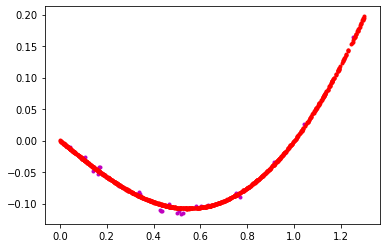

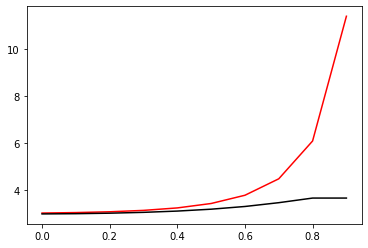

[2.9900618, 2.9999247, 3.0212028, 3.0566711, 3.1107976, 3.1904664, 3.30559, 3.4669418, 3.6627452, 3.6625452]
4101 tensor(0.0005)
4102 tensor(0.0004)
4103 tensor(0.0005)
4104 tensor(0.0004)
4105 tensor(0.0005)
4106 tensor(0.0005)
4107 tensor(0.0005)
4108 tensor(0.0004)
4109 tensor(0.0004)
4110 tensor(0.0004)
4111 tensor(0.0005)
4112 tensor(0.0005)
4113 tensor(0.0004)
4114 tensor(0.0004)
4115 tensor(0.0004)
4116 tensor(0.0004)
4117 tensor(0.0004)
4118 tensor(0.0005)
4119 tensor(0.0004)
4120 tensor(0.0004)
4121 tensor(0.0005)
4122 tensor(0.0004)
4123 tensor(0.0004)
4124 tensor(0.0005)
4125 tensor(0.0004)
4126 tensor(0.0006)
4127 tensor(0.0004)
4128 tensor(0.0004)
4129 tensor(0.0004)
4130 tensor(0.0004)
4131 tensor(0.0004)
4132 tensor(0.0004)
4133 tensor(0.0004)
4134 tensor(0.0004)
4135 tensor(0.0004)
4136 tensor(0.0004)
4137 tensor(0.0004)
4138 tensor(0.0004)
4139 tensor(0.0004)
4140 tensor(0.0006)
4141 tensor(0.0004)
4142 tensor(0.0005)
4143 tensor(0.0004)
4144 tensor(0.0005)
4145 tensor

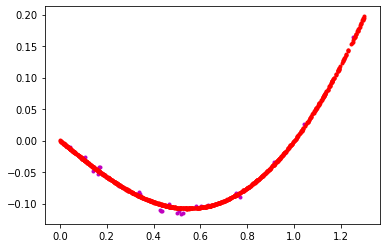

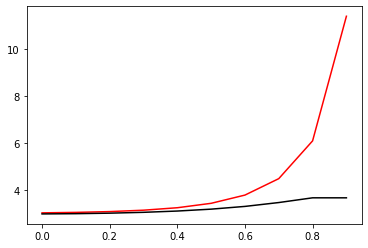

[2.9819221, 2.9921522, 3.0138614, 3.0496914, 3.1041675, 3.1844065, 3.3008034, 3.4649503, 3.6658428, 3.6656454]
4201 tensor(0.0004)
4202 tensor(0.0005)
4203 tensor(0.0004)
4204 tensor(0.0004)
4205 tensor(0.0005)
4206 tensor(0.0005)
4207 tensor(0.0005)
4208 tensor(0.0004)
4209 tensor(0.0005)
4210 tensor(0.0004)
4211 tensor(0.0004)
4212 tensor(0.0004)
4213 tensor(0.0005)
4214 tensor(0.0004)
4215 tensor(0.0004)
4216 tensor(0.0004)
4217 tensor(0.0005)
4218 tensor(0.0004)
4219 tensor(0.0004)
4220 tensor(0.0004)
4221 tensor(0.0004)
4222 tensor(0.0004)
4223 tensor(0.0004)
4224 tensor(0.0004)
4225 tensor(0.0005)
4226 tensor(0.0004)
4227 tensor(0.0005)
4228 tensor(0.0004)
4229 tensor(0.0004)
4230 tensor(0.0004)
4231 tensor(0.0004)
4232 tensor(0.0004)
4233 tensor(0.0005)
4234 tensor(0.0004)
4235 tensor(0.0005)
4236 tensor(0.0004)
4237 tensor(0.0005)
4238 tensor(0.0004)
4239 tensor(0.0004)
4240 tensor(0.0004)
4241 tensor(0.0004)
4242 tensor(0.0004)
4243 tensor(0.0004)
4244 tensor(0.0004)
4245 tens

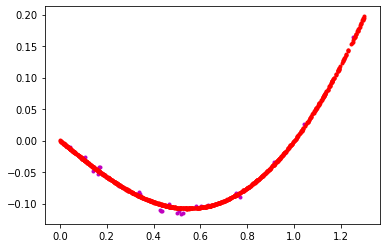

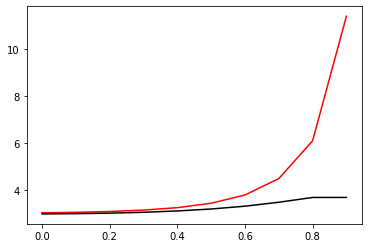

[2.9783766, 2.9887106, 3.010964, 3.048008, 3.1043987, 3.1872306, 3.306828, 3.474433, 3.6776829, 3.6786964]
4301 tensor(0.0004)
4302 tensor(0.0004)
4303 tensor(0.0005)
4304 tensor(0.0005)
4305 tensor(0.0004)
4306 tensor(0.0004)
4307 tensor(0.0004)
4308 tensor(0.0004)
4309 tensor(0.0003)
4310 tensor(0.0004)
4311 tensor(0.0004)
4312 tensor(0.0004)
4313 tensor(0.0004)
4314 tensor(0.0005)
4315 tensor(0.0004)
4316 tensor(0.0004)
4317 tensor(0.0004)
4318 tensor(0.0005)
4319 tensor(0.0004)
4320 tensor(0.0004)
4321 tensor(0.0005)
4322 tensor(0.0004)
4323 tensor(0.0004)
4324 tensor(0.0005)
4325 tensor(0.0004)
4326 tensor(0.0005)
4327 tensor(0.0004)
4328 tensor(0.0004)
4329 tensor(0.0005)
4330 tensor(0.0004)
4331 tensor(0.0004)
4332 tensor(0.0004)
4333 tensor(0.0004)
4334 tensor(0.0004)
4335 tensor(0.0004)
4336 tensor(0.0004)
4337 tensor(0.0005)
4338 tensor(0.0004)
4339 tensor(0.0004)
4340 tensor(0.0005)
4341 tensor(0.0004)
4342 tensor(0.0004)
4343 tensor(0.0005)
4344 tensor(0.0006)
4345 tensor(0

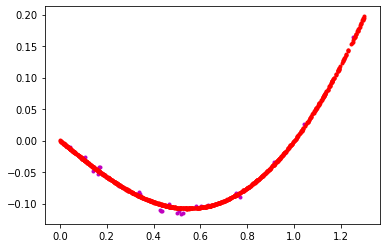

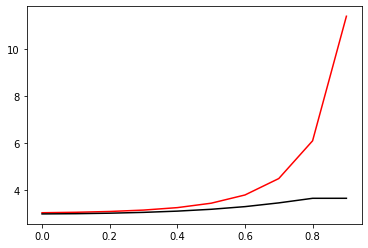

[2.9773355, 2.9870462, 3.0080676, 3.0429528, 3.095971, 3.1739335, 3.286901, 3.4461946, 3.6409314, 3.6414478]
4401 tensor(0.0005)
4402 tensor(0.0004)
4403 tensor(0.0004)
4404 tensor(0.0004)
4405 tensor(0.0004)
4406 tensor(0.0004)
4407 tensor(0.0004)
4408 tensor(0.0003)
4409 tensor(0.0004)
4410 tensor(0.0004)
4411 tensor(0.0004)
4412 tensor(0.0004)
4413 tensor(0.0004)
4414 tensor(0.0004)
4415 tensor(0.0005)
4416 tensor(0.0004)
4417 tensor(0.0004)
4418 tensor(0.0005)
4419 tensor(0.0004)
4420 tensor(0.0004)
4421 tensor(0.0004)
4422 tensor(0.0005)
4423 tensor(0.0005)
4424 tensor(0.0005)
4425 tensor(0.0004)
4426 tensor(0.0004)
4427 tensor(0.0005)
4428 tensor(0.0004)
4429 tensor(0.0005)
4430 tensor(0.0004)
4431 tensor(0.0004)
4432 tensor(0.0004)
4433 tensor(0.0005)
4434 tensor(0.0004)
4435 tensor(0.0004)
4436 tensor(0.0005)
4437 tensor(0.0005)
4438 tensor(0.0004)
4439 tensor(0.0004)
4440 tensor(0.0004)
4441 tensor(0.0004)
4442 tensor(0.0005)
4443 tensor(0.0005)
4444 tensor(0.0004)
4445 tensor

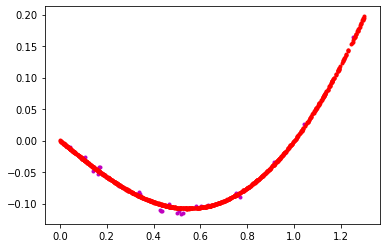

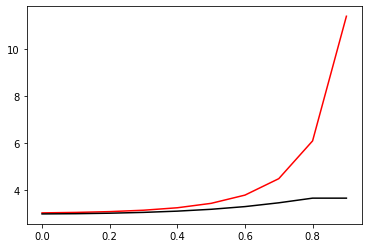

[2.9832897, 2.9928808, 3.0135925, 3.048223, 3.10129, 3.1798117, 3.2940373, 3.4554346, 3.6531162, 3.652751]
4501 tensor(0.0004)
4502 tensor(0.0005)
4503 tensor(0.0004)
4504 tensor(0.0004)
4505 tensor(0.0004)
4506 tensor(0.0005)
4507 tensor(0.0004)
4508 tensor(0.0005)
4509 tensor(0.0006)
4510 tensor(0.0005)
4511 tensor(0.0004)
4512 tensor(0.0004)
4513 tensor(0.0005)
4514 tensor(0.0004)
4515 tensor(0.0004)
4516 tensor(0.0004)
4517 tensor(0.0004)
4518 tensor(0.0004)
4519 tensor(0.0004)
4520 tensor(0.0005)
4521 tensor(0.0004)
4522 tensor(0.0005)
4523 tensor(0.0004)
4524 tensor(0.0005)
4525 tensor(0.0004)
4526 tensor(0.0003)
4527 tensor(0.0004)
4528 tensor(0.0004)
4529 tensor(0.0004)
4530 tensor(0.0005)
4531 tensor(0.0004)
4532 tensor(0.0004)
4533 tensor(0.0004)
4534 tensor(0.0004)
4535 tensor(0.0004)
4536 tensor(0.0004)
4537 tensor(0.0004)
4538 tensor(0.0005)
4539 tensor(0.0004)
4540 tensor(0.0004)
4541 tensor(0.0004)
4542 tensor(0.0004)
4543 tensor(0.0004)
4544 tensor(0.0004)
4545 tensor(0

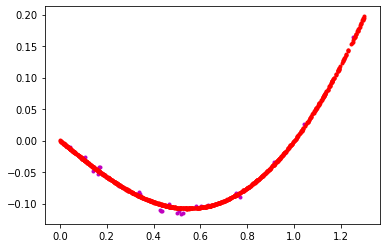

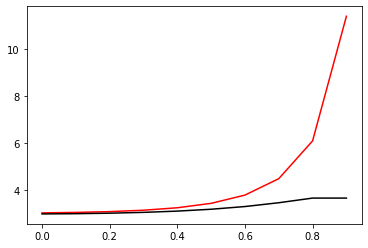

[2.9831355, 2.99294, 3.013953, 3.0489678, 3.1024916, 3.1815364, 3.2963133, 3.4580853, 3.655491, 3.655512]
4601 tensor(0.0004)
4602 tensor(0.0005)
4603 tensor(0.0004)
4604 tensor(0.0004)
4605 tensor(0.0004)
4606 tensor(0.0004)
4607 tensor(0.0004)
4608 tensor(0.0004)
4609 tensor(0.0004)
4610 tensor(0.0005)
4611 tensor(0.0004)
4612 tensor(0.0004)
4613 tensor(0.0003)
4614 tensor(0.0004)
4615 tensor(0.0005)
4616 tensor(0.0005)
4617 tensor(0.0004)
4618 tensor(0.0004)
4619 tensor(0.0004)
4620 tensor(0.0004)
4621 tensor(0.0004)
4622 tensor(0.0004)
4623 tensor(0.0004)
4624 tensor(0.0005)
4625 tensor(0.0004)
4626 tensor(0.0004)
4627 tensor(0.0004)
4628 tensor(0.0004)
4629 tensor(0.0004)
4630 tensor(0.0004)
4631 tensor(0.0004)
4632 tensor(0.0005)
4633 tensor(0.0004)
4634 tensor(0.0004)
4635 tensor(0.0003)
4636 tensor(0.0004)
4637 tensor(0.0004)
4638 tensor(0.0004)
4639 tensor(0.0005)
4640 tensor(0.0005)
4641 tensor(0.0005)
4642 tensor(0.0004)
4643 tensor(0.0004)
4644 tensor(0.0004)
4645 tensor(0.

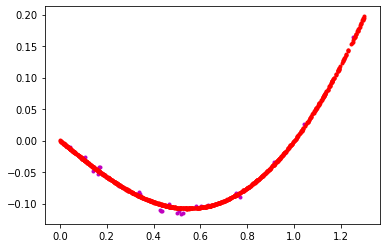

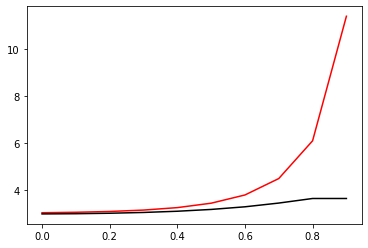

[2.9767752, 2.9857717, 3.005521, 3.038927, 3.0905268, 3.1672778, 3.279336, 3.4380844, 3.6325915, 3.6325216]
4701 tensor(0.0005)
4702 tensor(0.0004)
4703 tensor(0.0004)
4704 tensor(0.0004)
4705 tensor(0.0004)
4706 tensor(0.0004)
4707 tensor(0.0004)
4708 tensor(0.0004)
4709 tensor(0.0005)
4710 tensor(0.0004)
4711 tensor(0.0005)
4712 tensor(0.0004)
4713 tensor(0.0004)
4714 tensor(0.0004)
4715 tensor(0.0004)
4716 tensor(0.0004)
4717 tensor(0.0005)
4718 tensor(0.0004)
4719 tensor(0.0004)
4720 tensor(0.0004)
4721 tensor(0.0004)
4722 tensor(0.0004)
4723 tensor(0.0004)
4724 tensor(0.0004)
4725 tensor(0.0004)
4726 tensor(0.0004)
4727 tensor(0.0004)
4728 tensor(0.0004)
4729 tensor(0.0005)
4730 tensor(0.0004)
4731 tensor(0.0004)
4732 tensor(0.0005)
4733 tensor(0.0005)
4734 tensor(0.0005)
4735 tensor(0.0004)
4736 tensor(0.0004)
4737 tensor(0.0004)
4738 tensor(0.0004)
4739 tensor(0.0004)
4740 tensor(0.0004)
4741 tensor(0.0004)
4742 tensor(0.0004)
4743 tensor(0.0004)
4744 tensor(0.0004)
4745 tensor(

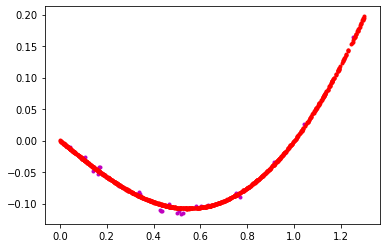

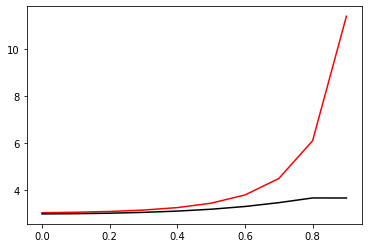

[2.9764152, 2.9861007, 3.007128, 3.0423057, 3.0961883, 3.175877, 3.2917097, 3.4550977, 3.6545098, 3.6531816]
4801 tensor(0.0004)
4802 tensor(0.0004)
4803 tensor(0.0005)
4804 tensor(0.0004)
4805 tensor(0.0004)
4806 tensor(0.0005)
4807 tensor(0.0004)
4808 tensor(0.0005)
4809 tensor(0.0004)
4810 tensor(0.0004)
4811 tensor(0.0004)
4812 tensor(0.0004)
4813 tensor(0.0005)
4814 tensor(0.0004)
4815 tensor(0.0004)
4816 tensor(0.0005)
4817 tensor(0.0005)
4818 tensor(0.0005)
4819 tensor(0.0004)
4820 tensor(0.0005)
4821 tensor(0.0004)
4822 tensor(0.0004)
4823 tensor(0.0004)
4824 tensor(0.0004)
4825 tensor(0.0004)
4826 tensor(0.0004)
4827 tensor(0.0004)
4828 tensor(0.0005)
4829 tensor(0.0004)
4830 tensor(0.0005)
4831 tensor(0.0004)
4832 tensor(0.0004)
4833 tensor(0.0004)
4834 tensor(0.0004)
4835 tensor(0.0005)
4836 tensor(0.0004)
4837 tensor(0.0004)
4838 tensor(0.0005)
4839 tensor(0.0004)
4840 tensor(0.0004)
4841 tensor(0.0006)
4842 tensor(0.0005)
4843 tensor(0.0004)
4844 tensor(0.0004)
4845 tensor

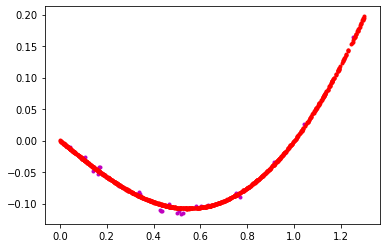

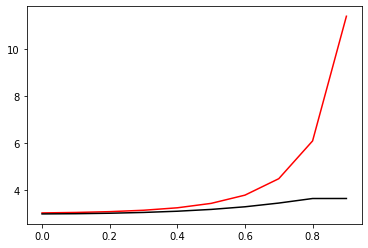

[2.9847388, 2.9937916, 3.013713, 3.0473177, 3.0990577, 3.1758013, 3.287568, 3.4455755, 3.6389697, 3.6397038]
4901 tensor(0.0004)
4902 tensor(0.0004)
4903 tensor(0.0004)
4904 tensor(0.0004)
4905 tensor(0.0004)
4906 tensor(0.0004)
4907 tensor(0.0004)
4908 tensor(0.0005)
4909 tensor(0.0004)
4910 tensor(0.0006)
4911 tensor(0.0005)
4912 tensor(0.0004)
4913 tensor(0.0004)
4914 tensor(0.0004)
4915 tensor(0.0005)
4916 tensor(0.0004)
4917 tensor(0.0004)
4918 tensor(0.0005)
4919 tensor(0.0005)
4920 tensor(0.0004)
4921 tensor(0.0004)
4922 tensor(0.0004)
4923 tensor(0.0004)
4924 tensor(0.0004)
4925 tensor(0.0004)
4926 tensor(0.0004)
4927 tensor(0.0005)
4928 tensor(0.0004)
4929 tensor(0.0005)
4930 tensor(0.0004)
4931 tensor(0.0005)
4932 tensor(0.0005)
4933 tensor(0.0004)
4934 tensor(0.0004)
4935 tensor(0.0004)
4936 tensor(0.0004)
4937 tensor(0.0005)
4938 tensor(0.0004)
4939 tensor(0.0005)
4940 tensor(0.0004)
4941 tensor(0.0004)
4942 tensor(0.0004)
4943 tensor(0.0004)
4944 tensor(0.0005)
4945 tensor

In [10]:
total_epoch=5000
show_epoch_each=100
for epoch in range (total_epoch):
    batches=iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_pi, b_ans) in batches:
        phi, pi, ans = Variable(b_phi), Variable(b_pi), Variable(b_ans)
        loss = Test.loss(phi=phi, pi=pi, answer=ans)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
    print(epoch, train_loss/len(train_d_loader))
    if np.isnan(train_loss)==True: break
        
    if epoch % show_epoch_each == 0:
        nx, ny, px, py, Hs = plot_metric(threshold=0.1, 
                                         Positive_HM=Positive_HM, Negative_HM=Negative_HM, Net=Test)
        print(Test.show_Hs())

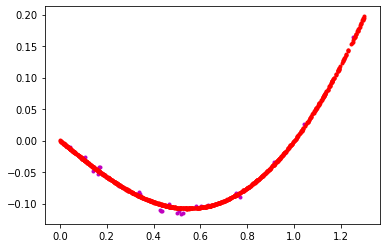

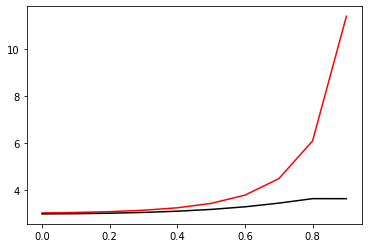

[2.9844863, 2.9940388, 3.014406, 3.0481381, 3.099632, 3.1757102, 3.2862287, 3.4421642, 3.6330628, 3.6313229]


In [11]:
nx, ny, px, py, Hs = plot_metric(threshold=0.1, 
                                         Positive_HM=Positive_HM, Negative_HM=Negative_HM, Net=Test)
print(Test.show_Hs())